<a href="https://colab.research.google.com/github/arashms/DL-project/blob/DataPreparationForTFT/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DATA_DIR = "/content/gdrive/MyDrive/DL-proj/"
DATA_FILE = "data.xlsx"
RANDOM_SEED = 754

MAX_PREDICTION_LENGTH = 15
MAX_ENCODER_LENGTH = 60
MIN_ENCODER_LENGTH = MAX_ENCODER_LENGTH // 2

BATCH_SIZE = 128

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
!cp {DATA_DIR + DATA_FILE} /content/

Mounted at /content/gdrive/


###TFT

In [3]:
import pandas as pd
import torch

!pip install pytorch_lightning > /dev/null
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor
)

!pip install pytorch_forecasting > /dev/null
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)


In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU available, using cuda.')
    torch.cuda.manual_seed_all(RANDOM_SEED) #for reproducablity
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU available, using cuda.


In [5]:
xl_file = pd.ExcelFile(DATA_FILE)

sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

data = sheets['main']

print('\n', data.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74200 entries, 0 to 74199
Columns: 126 entries, time_idx to negative-comment-embedding19
dtypes: float64(40), int64(84), object(2)
memory usage: 71.3+ MB

 None 



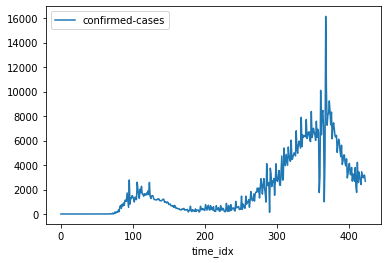

In [6]:
data[data.country=='Canada'].plot(x='time_idx', y='confirmed-cases')


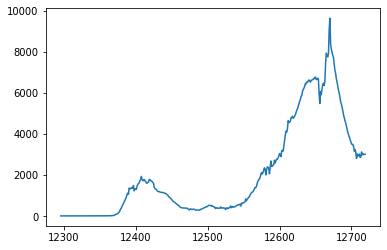

In [9]:
data[data.country=='Canada']['confirmed-cases'].rolling(7).mean().fillna(0).round().astype('int').plot()

In [10]:
for country in data.country.unique():
    data.loc[data.country == country, 'avg7_confirmed_cases'] =\
     data[data.country==country]['confirmed-cases'].rolling(7).\
                                                    mean().\
                                                    fillna(0).\
                                                    round().\
                                                    astype('int')

In [11]:
data.sample(5)

,time_idx,country,region,confirmed-cases,positive-Public health measures,positive-Movement restrictions,positive-Governance and socio-economic measures,positive-Social distancing,positive-Lockdown,positive-Humanitarian exemption,positive-Awareness campaigns,positive-Health screenings in airports and border crossings,positive-International flights suspension,positive-Border checks,positive-Strengthening the public health system,positive-Isolation and quarantine policies,positive-Emergency administrative structures activated or established,positive-Surveillance and monitoring,positive-Other public health measures enforced,positive-Border closure,positive-General recommendations,positive-State of emergency declared,positive-Domestic travel restrictions,positive-Limit public gatherings,positive-Limit product imports/exports,positive-Schools closure,positive-Partial lockdown,positive-Changes in prison-related policies,positive-Closure of businesses and public services,positive-Checkpoints within the country,positive-Economic measures,positive-Military deployment,positive-Curfews,positive-Visa restrictions,positive-Requirement to wear protective gear in public,positive-Testing policy,positive-Amendments to funeral and burial regulations,positive-Full lockdown,positive-Lockdown of refugee/idp camps or other minorities,positive-Additional health/documents requirements upon arrival,...,negative-Partial lockdown,negative-Changes in prison-related policies,negative-Closure of businesses and public services,negative-Checkpoints within the country,negative-Economic measures,negative-Military deployment,negative-Curfews,negative-Visa restrictions,negative-Requirement to wear protective gear in public,negative-Testing policy,negative-Amendments to funeral and burial regulations,negative-Full lockdown,negative-Lockdown of refugee/idp camps or other minorities,negative-Additional health/documents requirements upon arrival,negative-Mass population testing,negative-Humanitarian exemptions,negative-Psychological assistance and medical social work,negative-Complete border closure,negative-Obligatory medical tests not related to COVID-19,negative-comment-embedding0,negative-comment-embedding1,negative-comment-embedding2,negative-comment-embedding3,negative-comment-embedding4,negative-comment-embedding5,negative-comment-embedding6,negative-comment-embedding7,negative-comment-embedding8,negative-comment-embedding9,negative-comment-embedding10,negative-comment-embedding11,negative-comment-embedding12,negative-comment-embedding13,negative-comment-embedding14,negative-comment-embedding15,negative-comment-embedding16,negative-comment-embedding17,negative-comment-embedding18,negative-comment-embedding19,avg7_confirmed_cases
19627,123,Egypt,Africa,272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.082393,-0.817131,-2.584286,3.001755,2.440631,0.525109,-0.20192,0.03319,-0.022766,0.022508,0.029835,-0.023036,0.092301,-0.010764,0.003988,-0.090873,-0.035729,0.008969,0.020537,-0.08679,276.0
62067,163,South Africa,Africa,3359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2642.0
19564,60,Egypt,Africa,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
53944,96,Poland,Europe,311,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [12]:
feature_list = [i for i in data.columns if 'positive' in i or 'negative' in i]

In [13]:
training_cutoff = data['time_idx'].max() - MAX_PREDICTION_LENGTH - 30

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='avg7_confirmed_cases',
    group_ids=['country'],
    weight=None,
    min_encoder_length=MIN_ENCODER_LENGTH,
    max_encoder_length=MIN_ENCODER_LENGTH,
    min_prediction_length=1,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=['country', 'region'],
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_reals=feature_list,
    
    # target_normalizer=GroupNormalizer(
    #     groups=["country"], transformation="softplus"
    # )
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(
    training, 
    data[lambda x: x.time_idx <= training_cutoff+MAX_PREDICTION_LENGTH],
    predict=True, stop_randomization=True
)


In [14]:
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE,
    num_workers=0                                     
)

val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE*10,
    num_workers=0
)

In [15]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lightning_logs')

### Finding Optimal Learning Rate

In [16]:
pl.seed_everything(RANDOM_SEED)
trainer = pl.Trainer(
    gpus = [0],
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 754
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 106.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.8 K 
3  | prescalers                         | ModuleDict                      | 2.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 86.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate: 5.888436553555889e-06


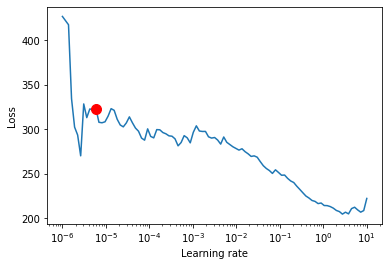

In [17]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [18]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# create trainer
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],  # train on CPU, use gpus = [0] to run on GPU
    gradient_clip_val=0.1,
    weights_summary='top',
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)
tft.size() # 29.6k parameters in model
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 5.1 K 
3  | prescalers                         | ModuleDict                      | 2.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 153 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedR

1

In [19]:
best_tft = tft
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1446.9293)

In [20]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)


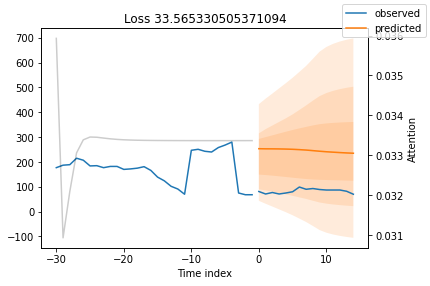

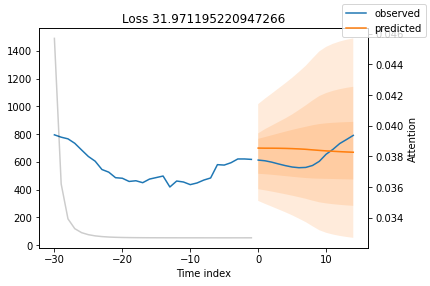

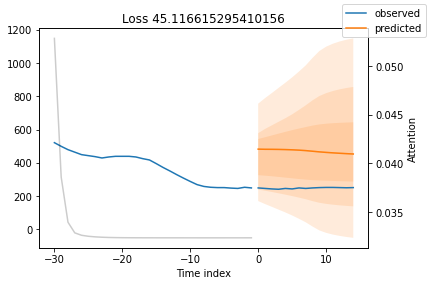

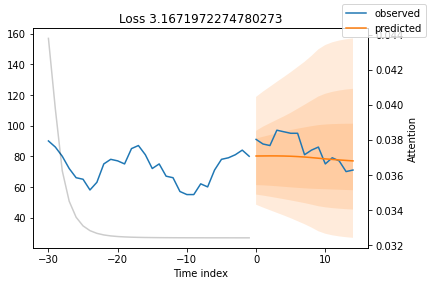

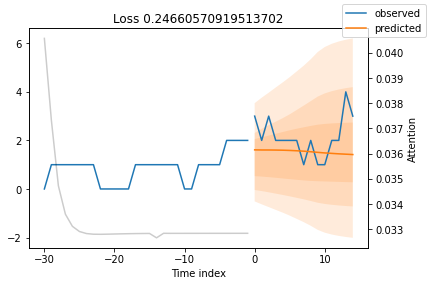

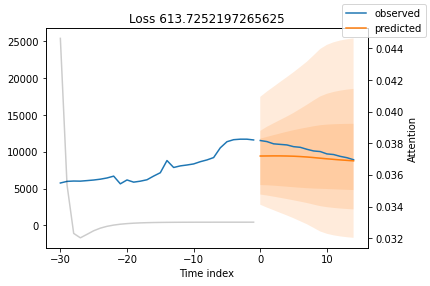

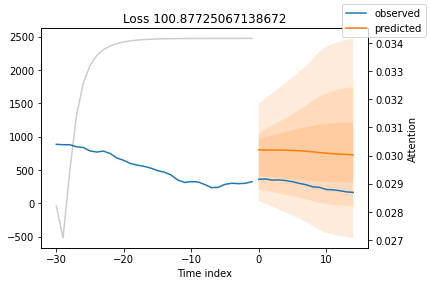

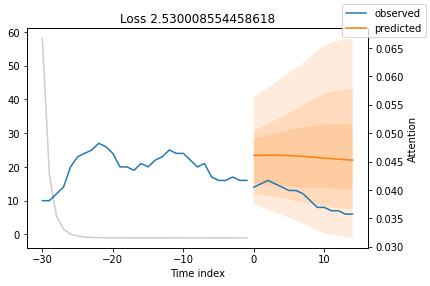

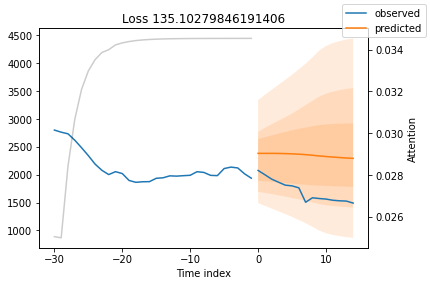

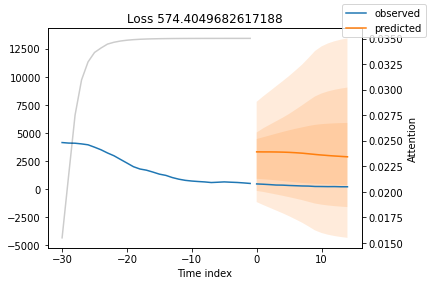

In [21]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are r

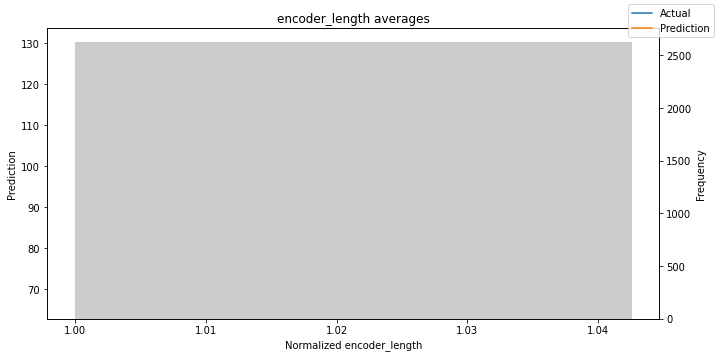

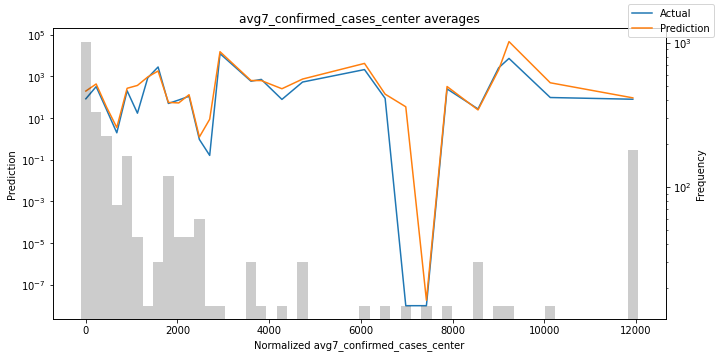

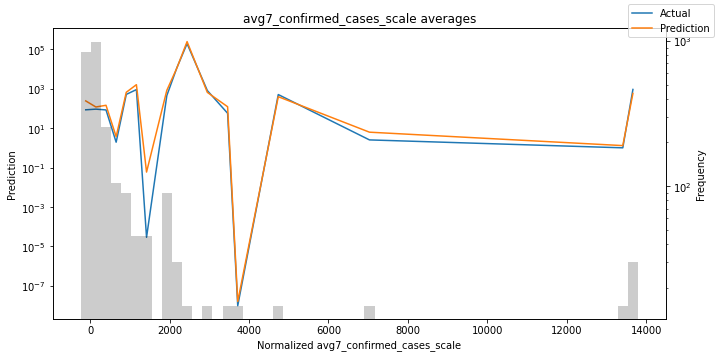

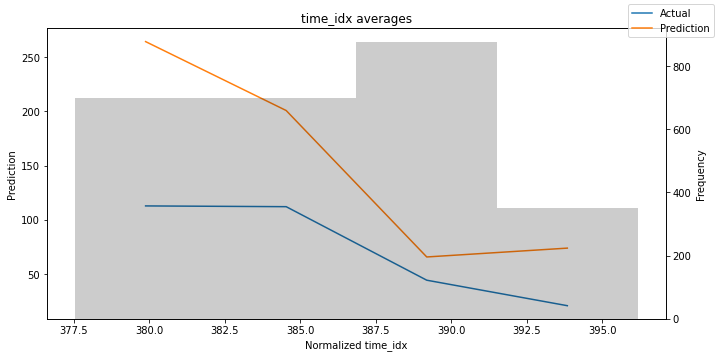

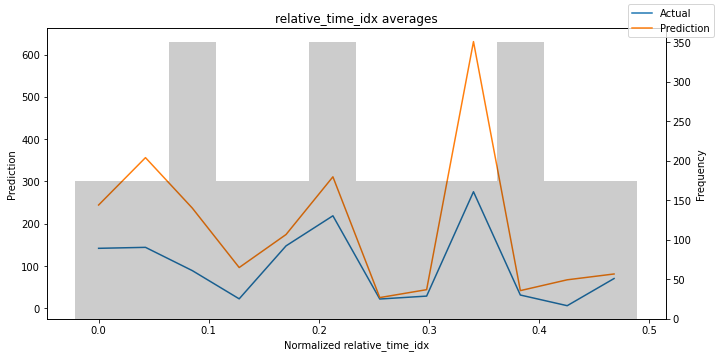

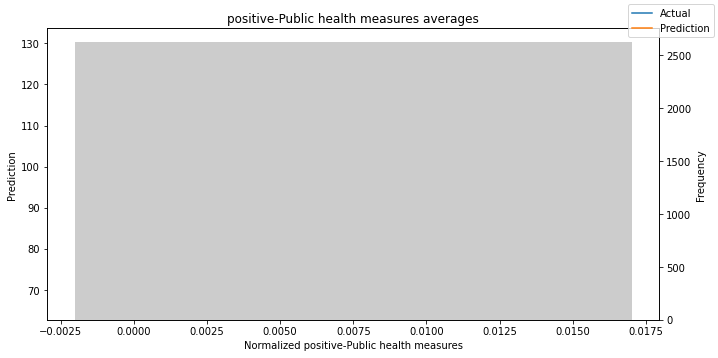

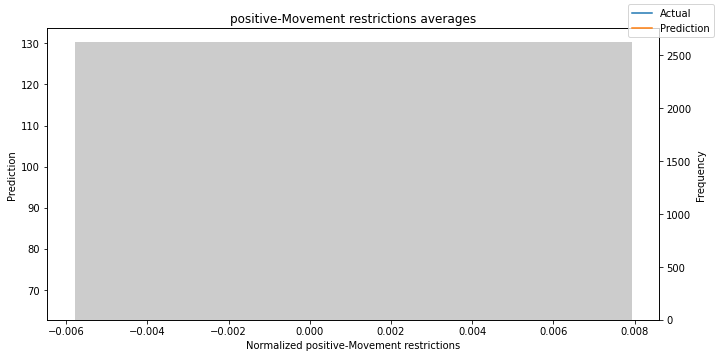

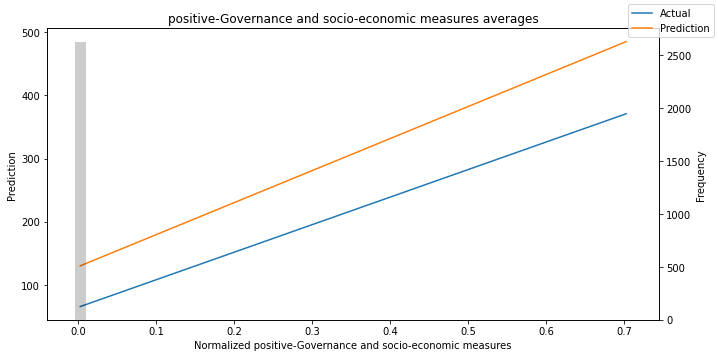

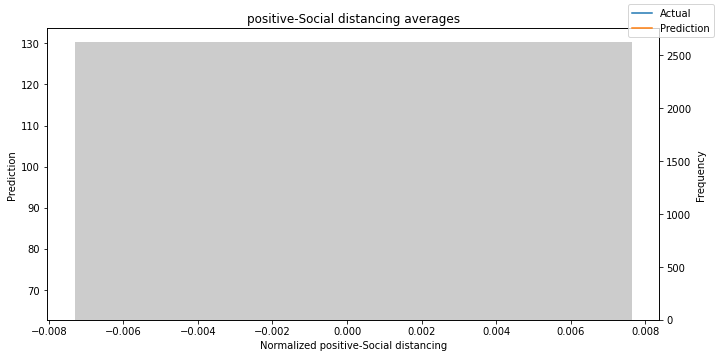

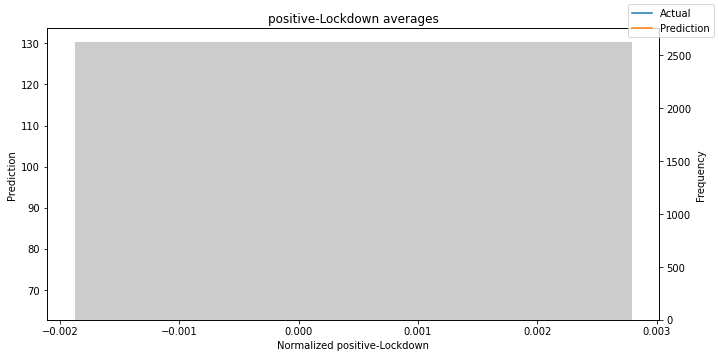

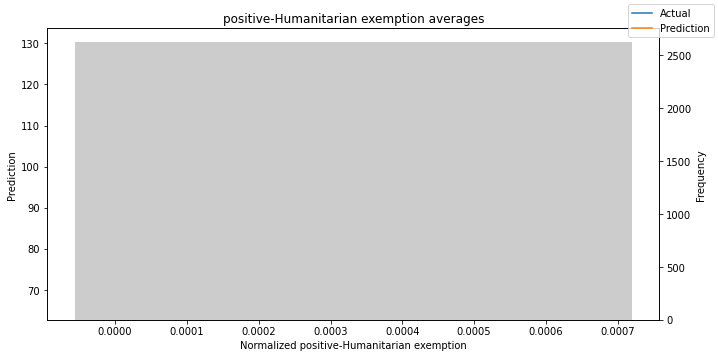

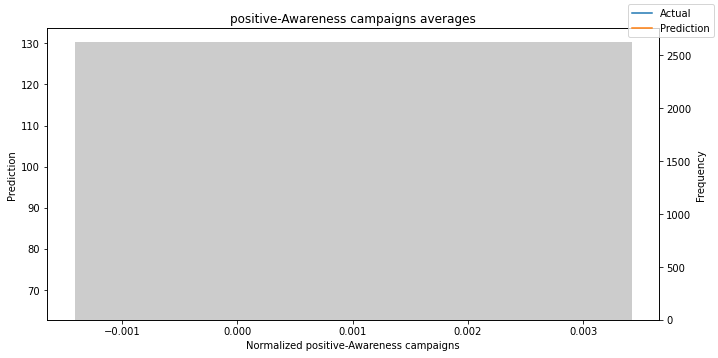

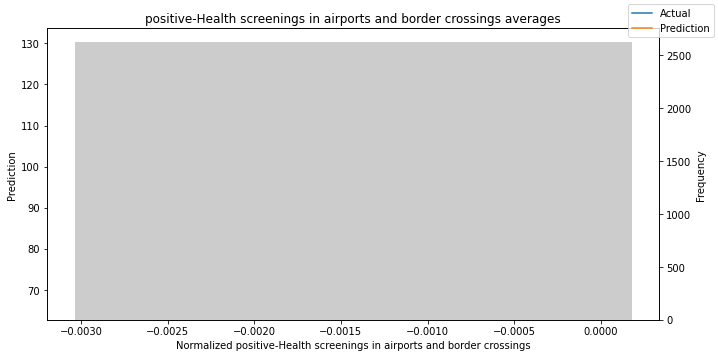

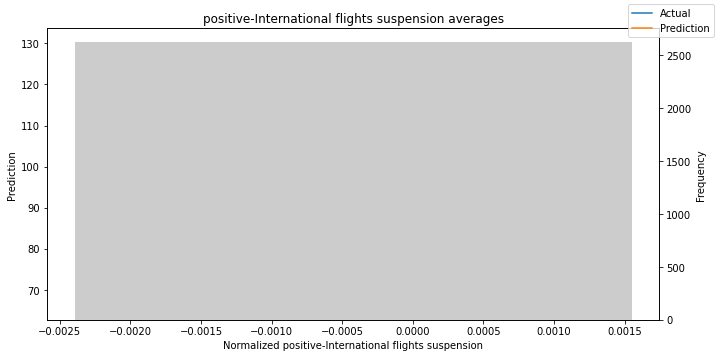

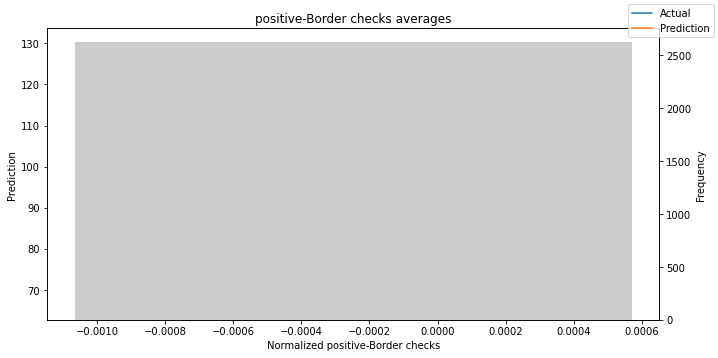

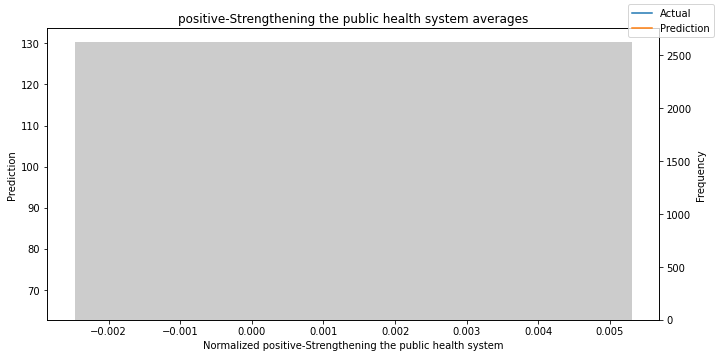

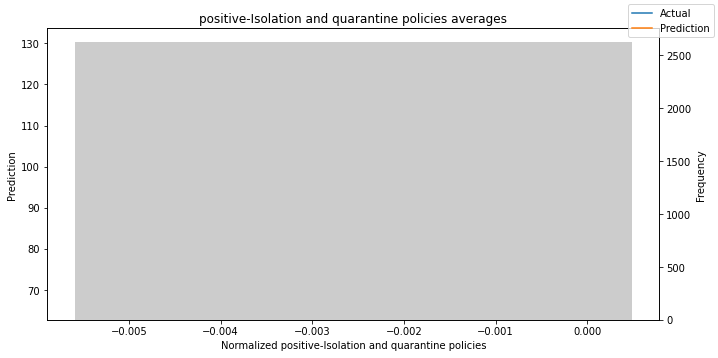

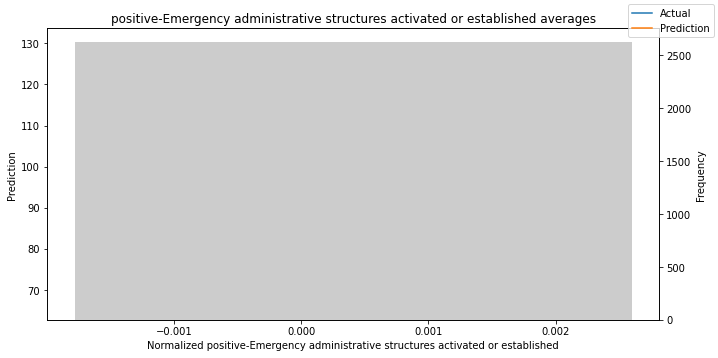

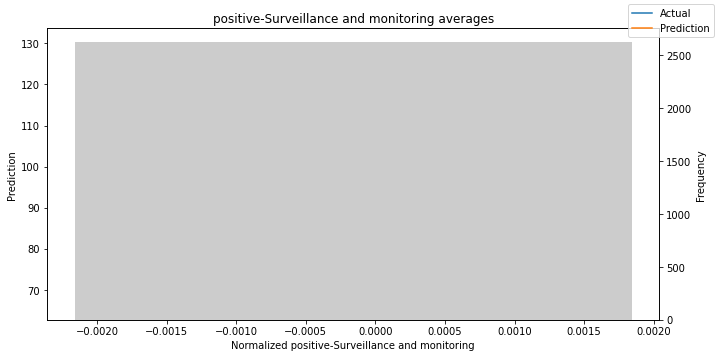

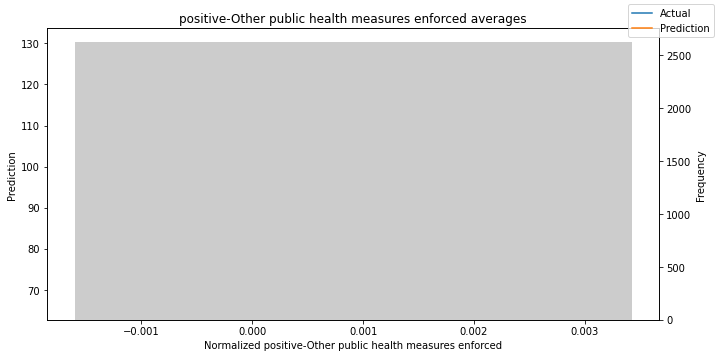

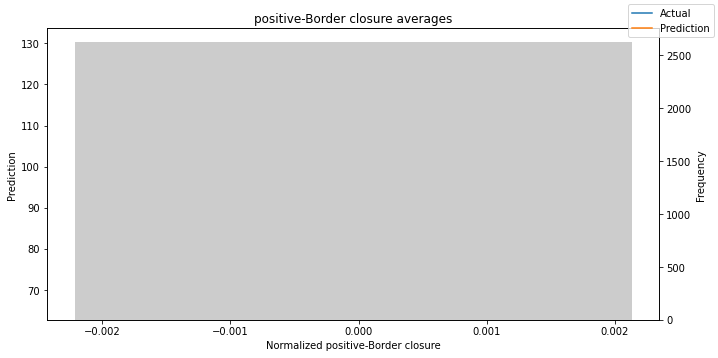

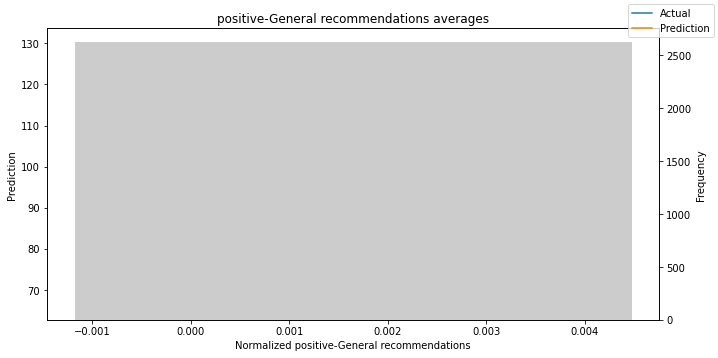

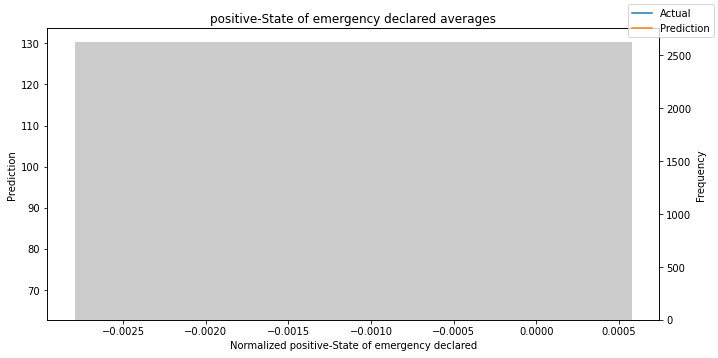

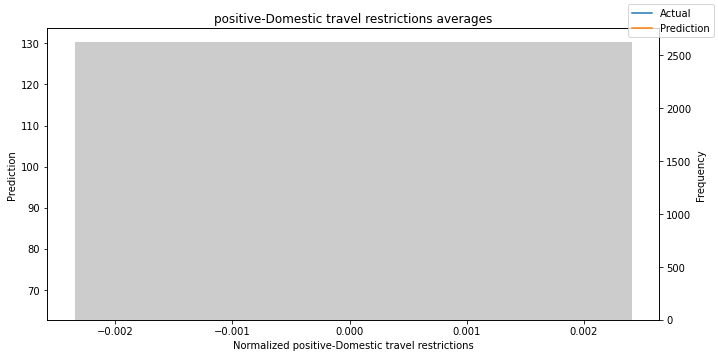

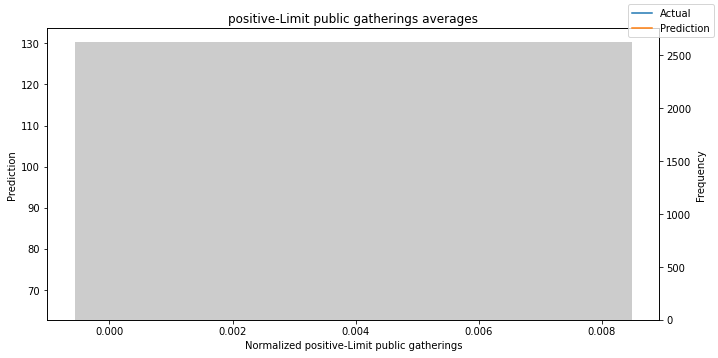

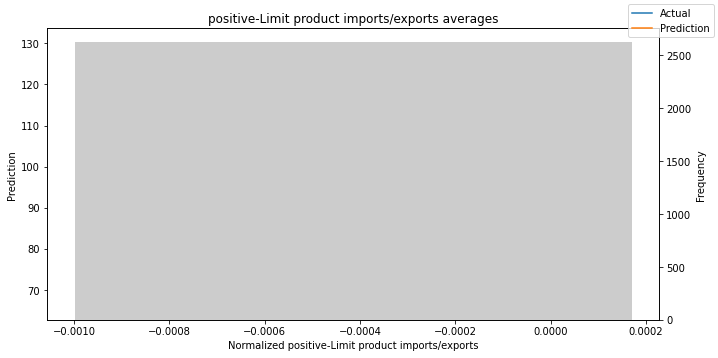

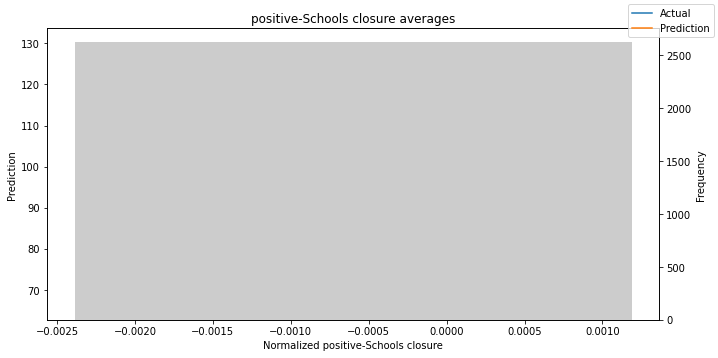

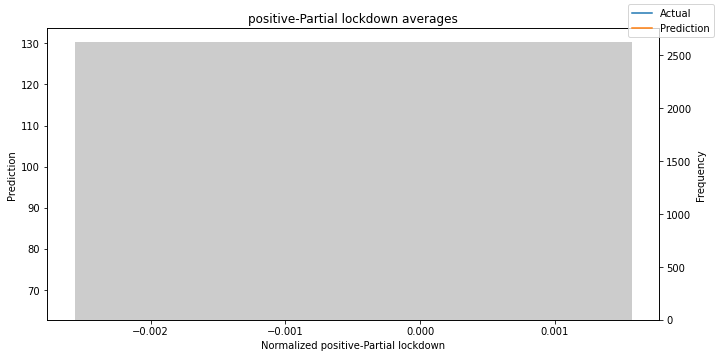

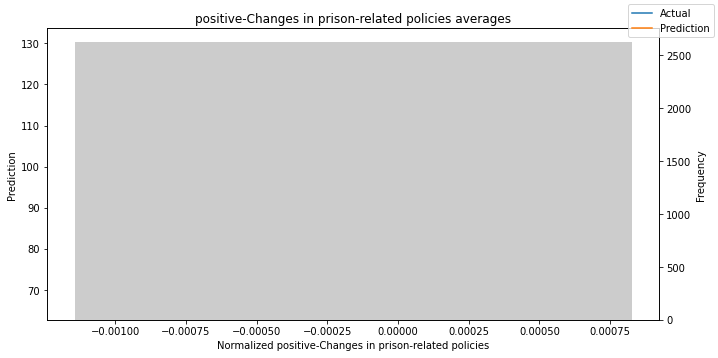

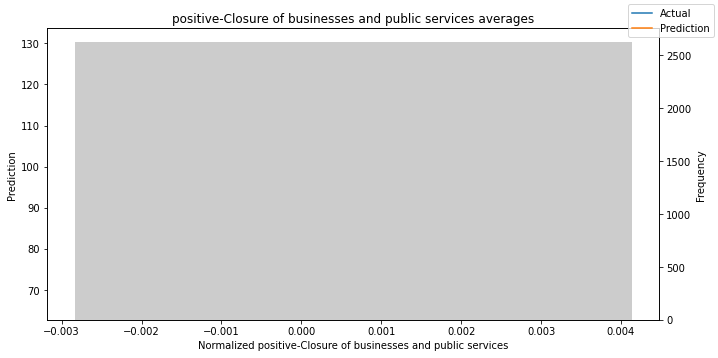

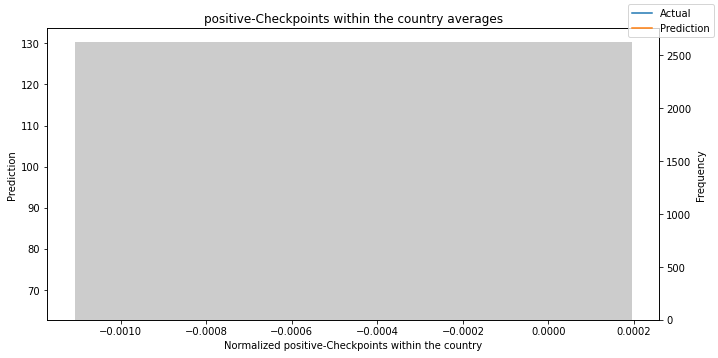

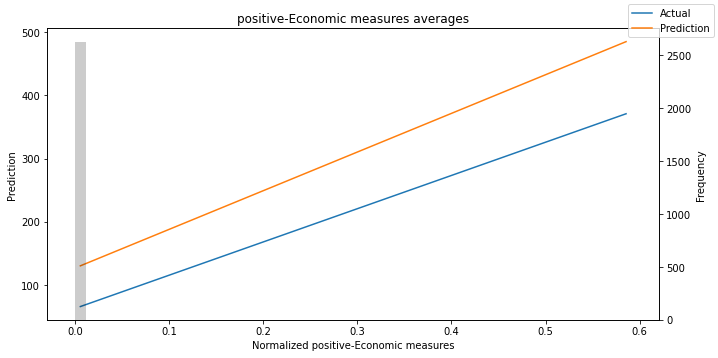

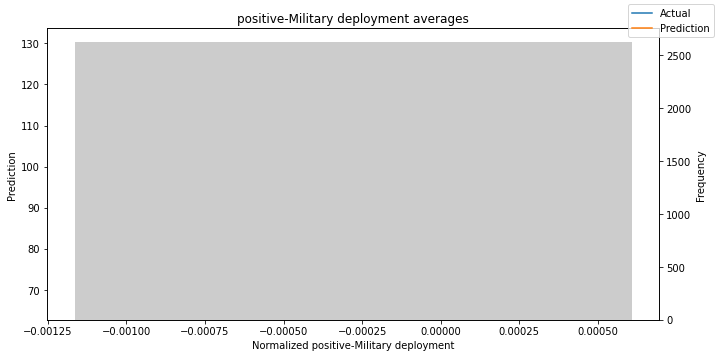

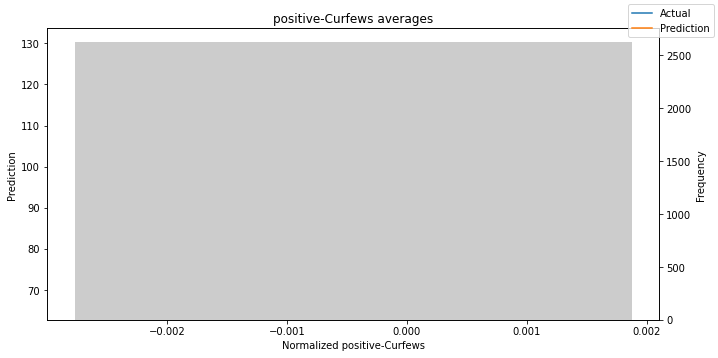

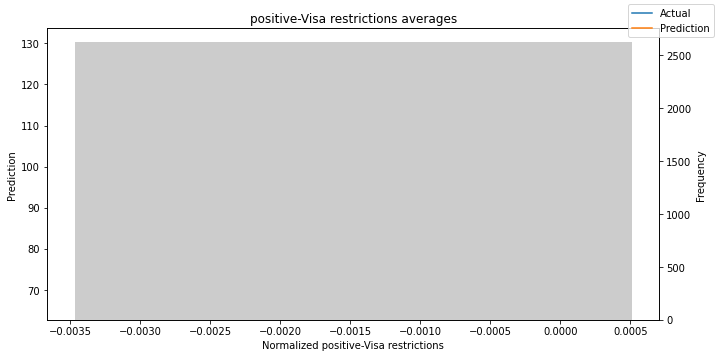

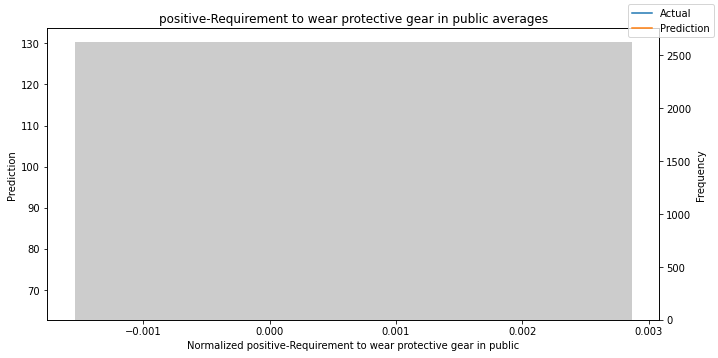

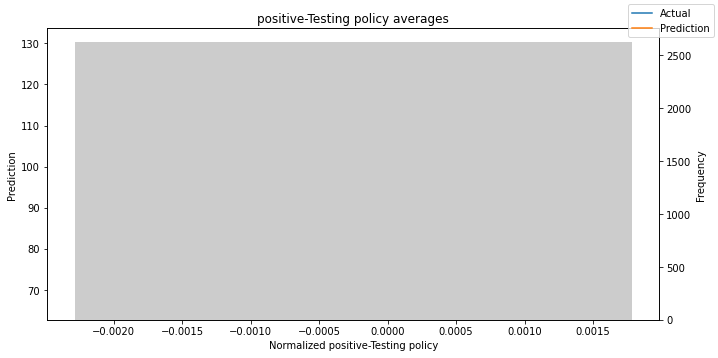

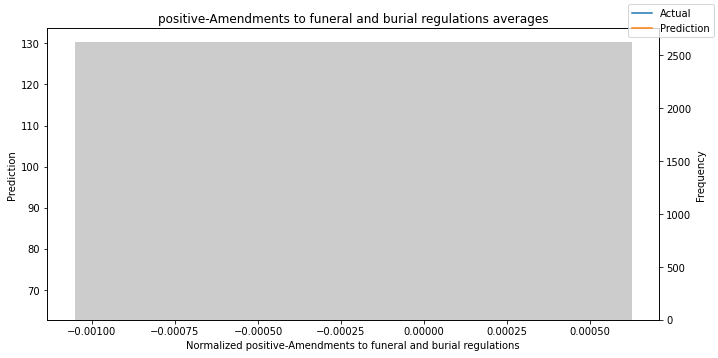

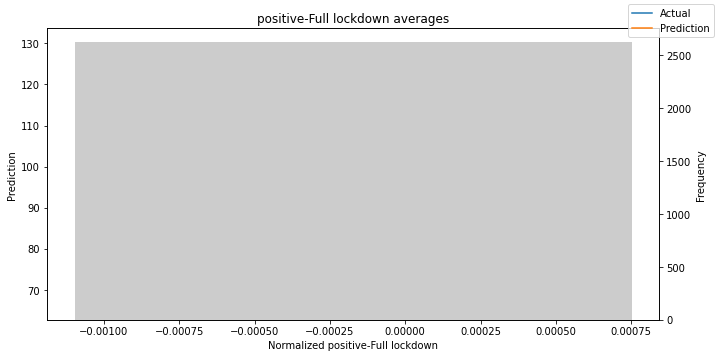

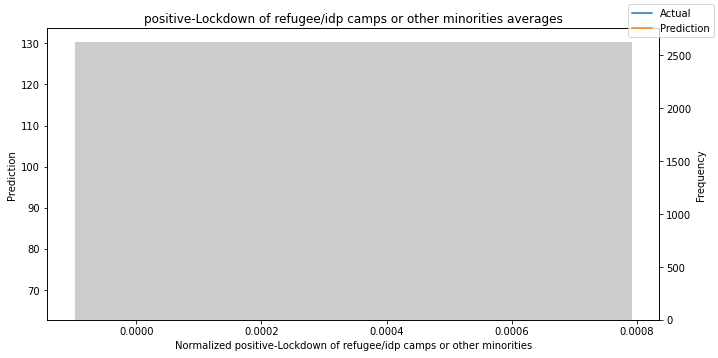

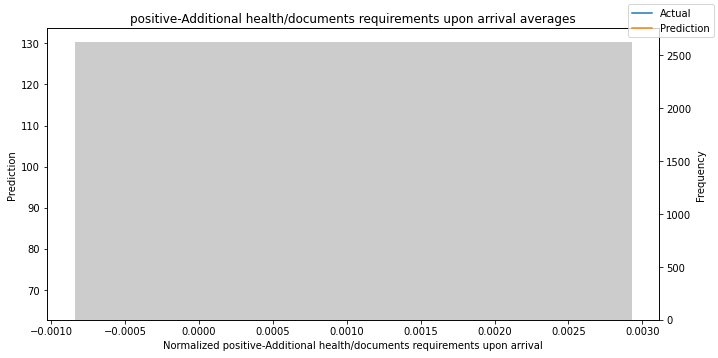

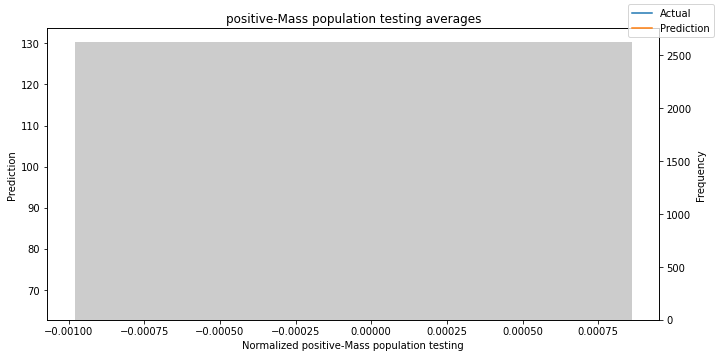

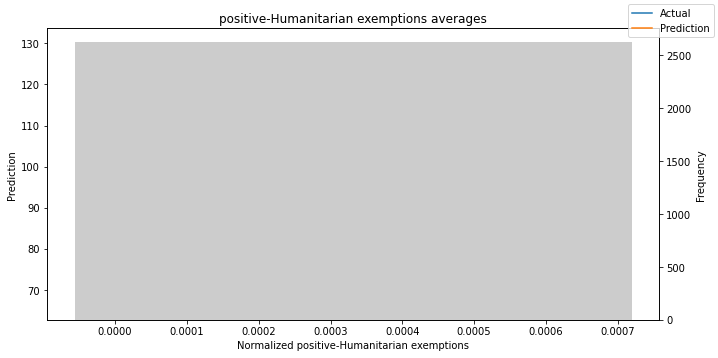

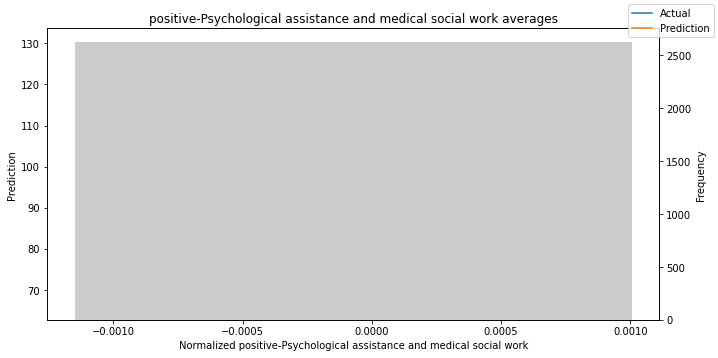

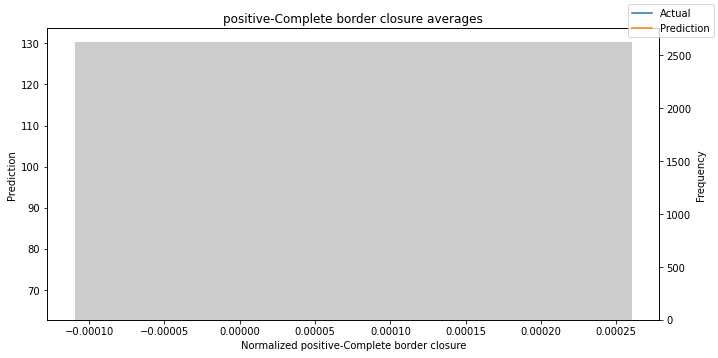

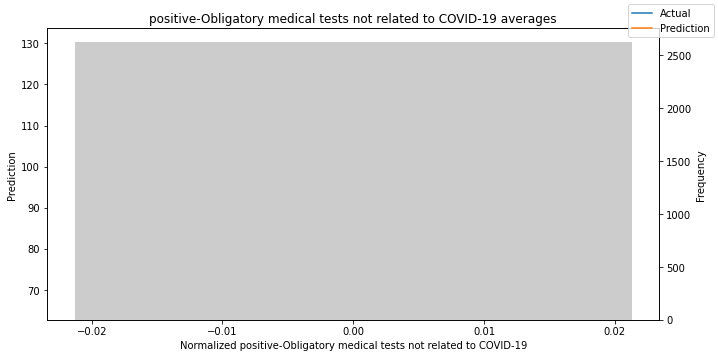

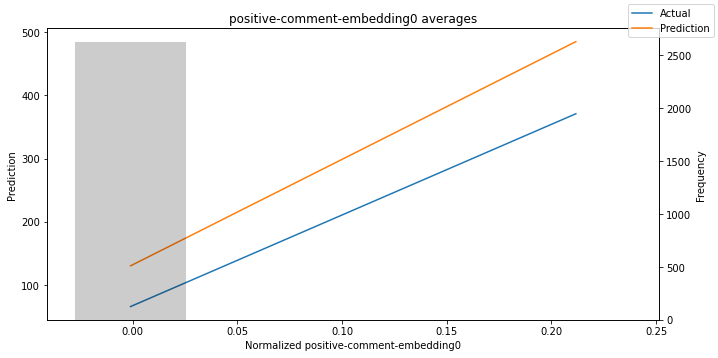

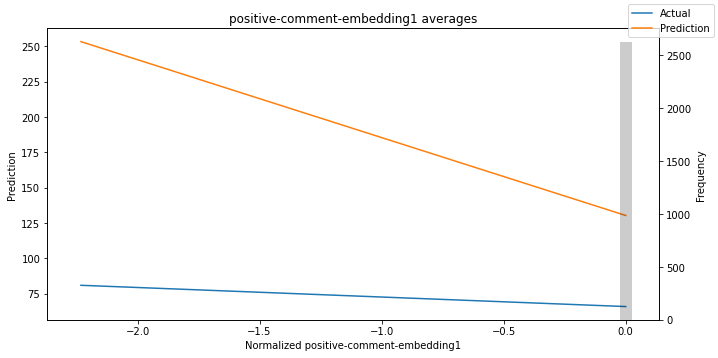

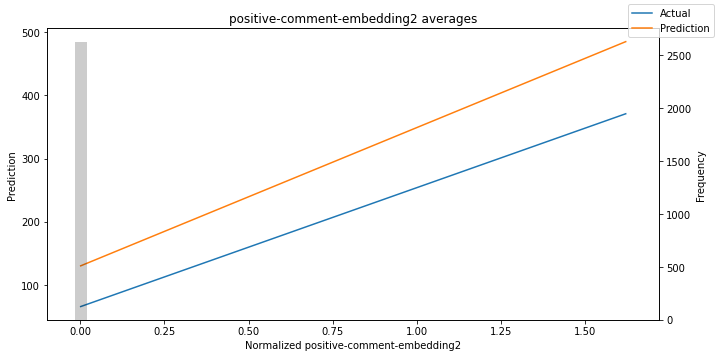

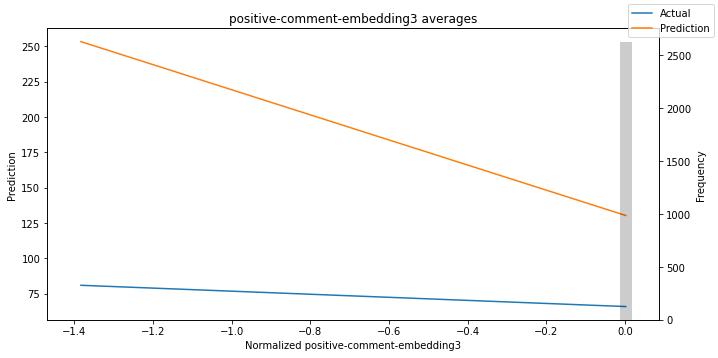

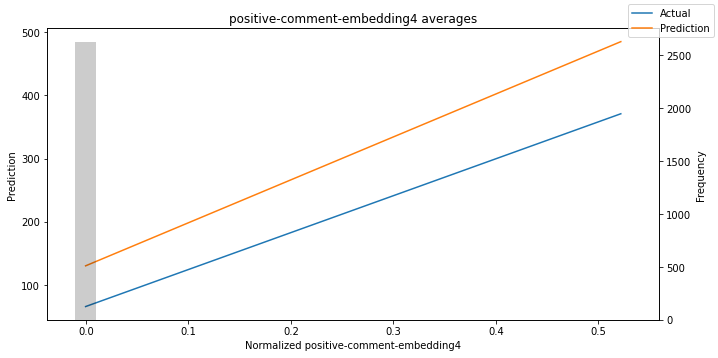

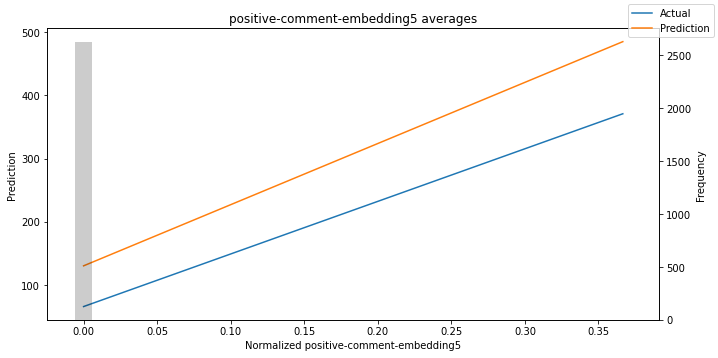

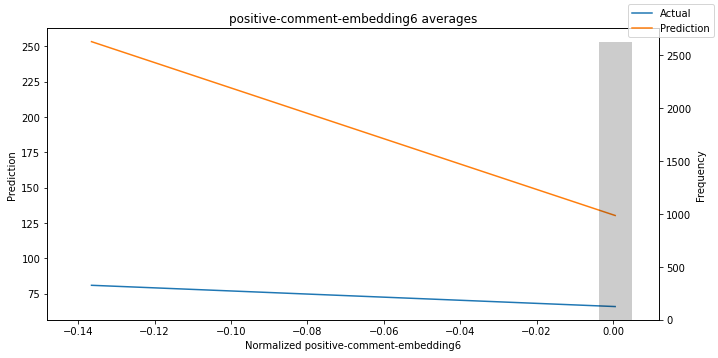

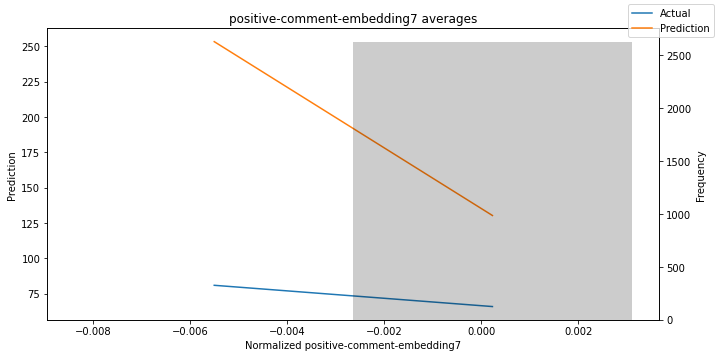

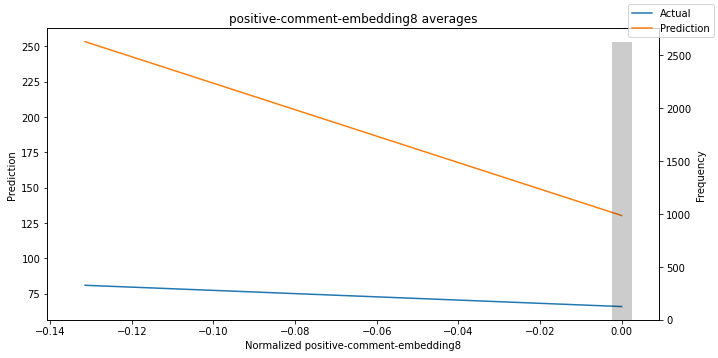

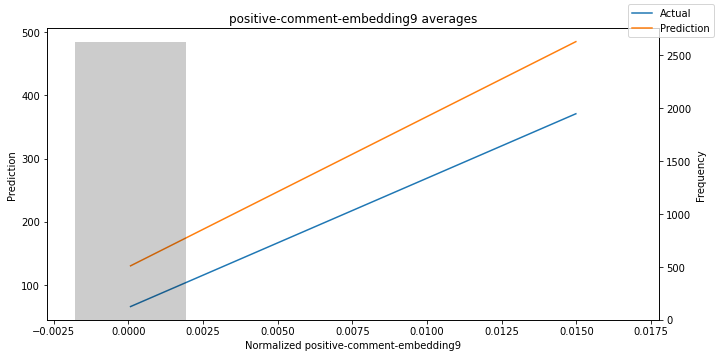

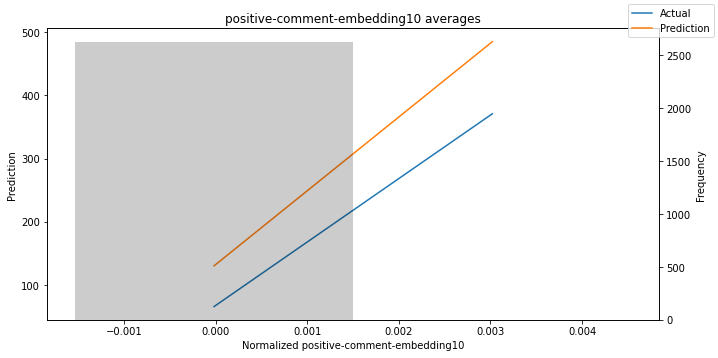

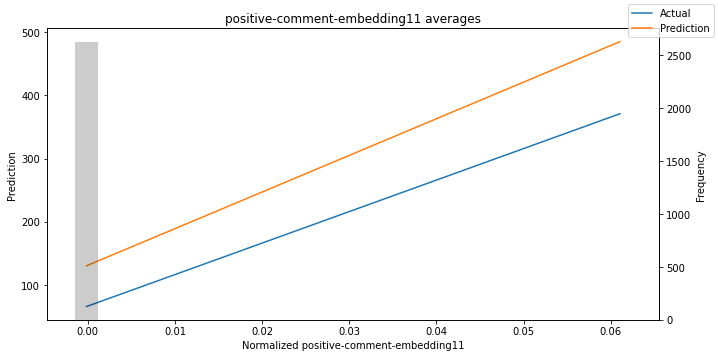

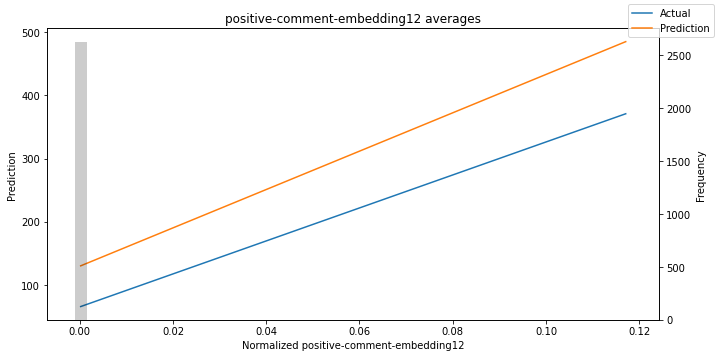

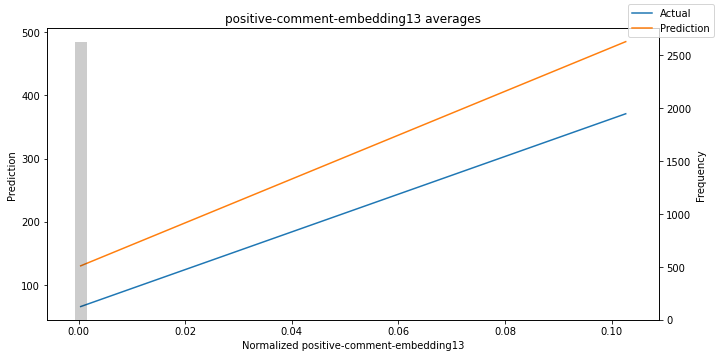

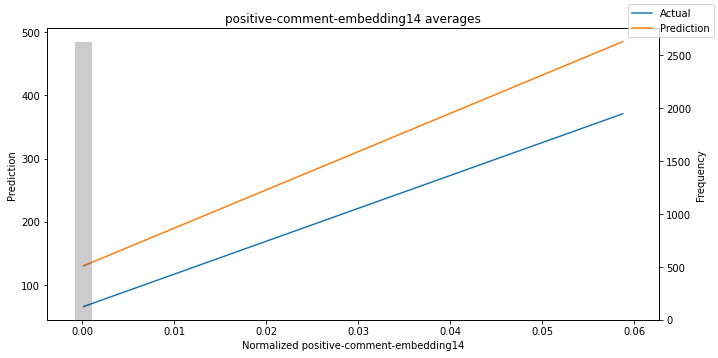

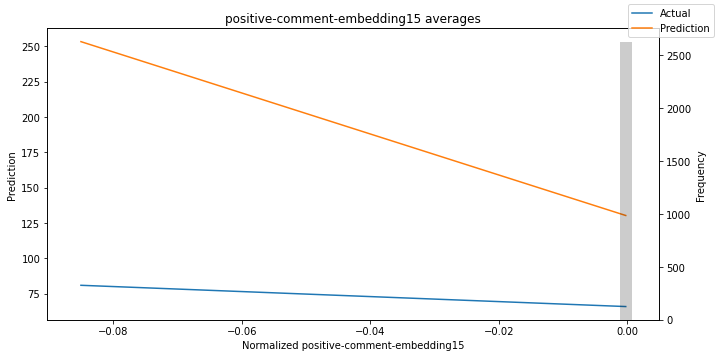

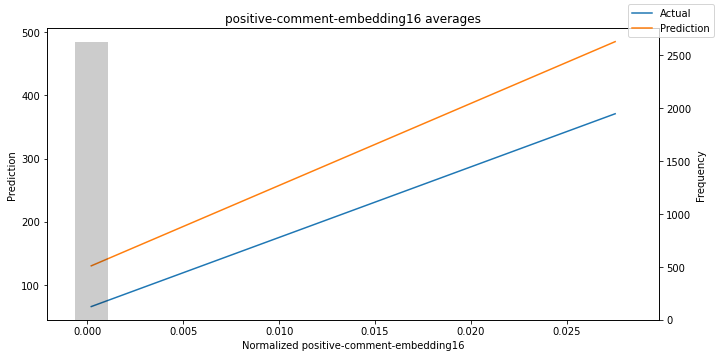

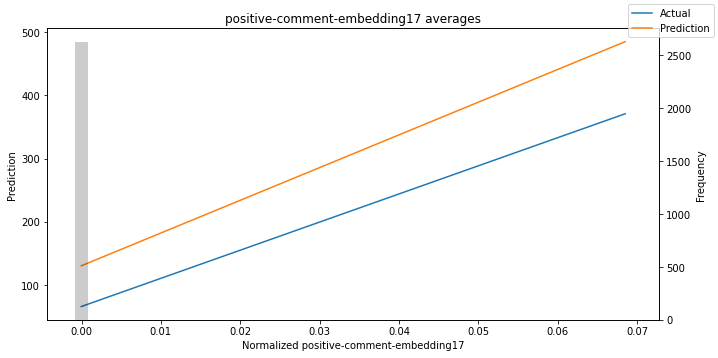

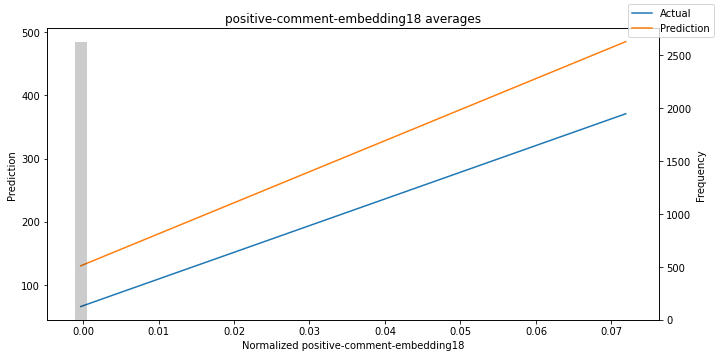

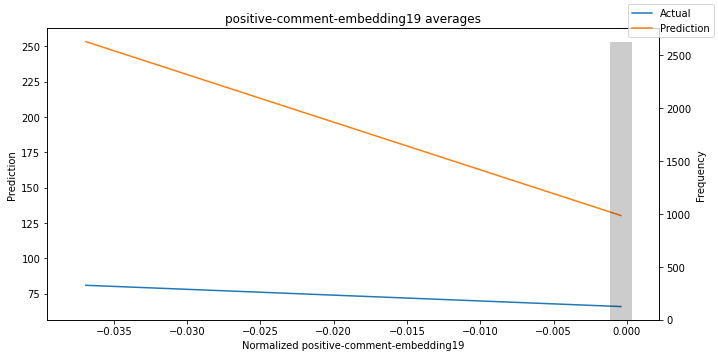

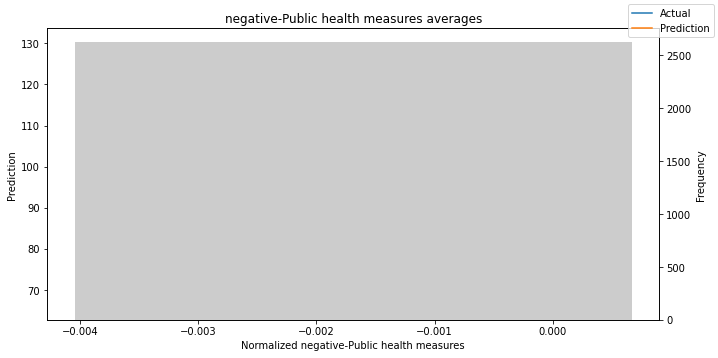

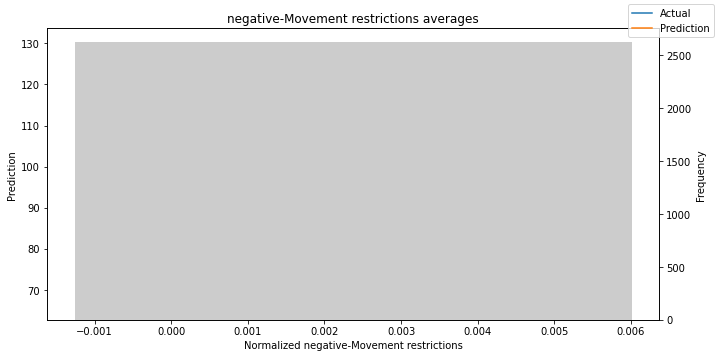

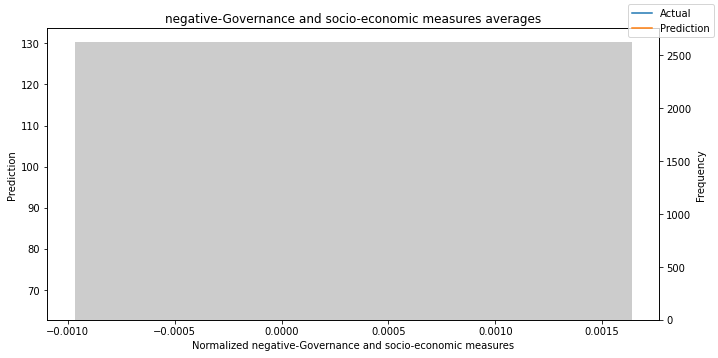

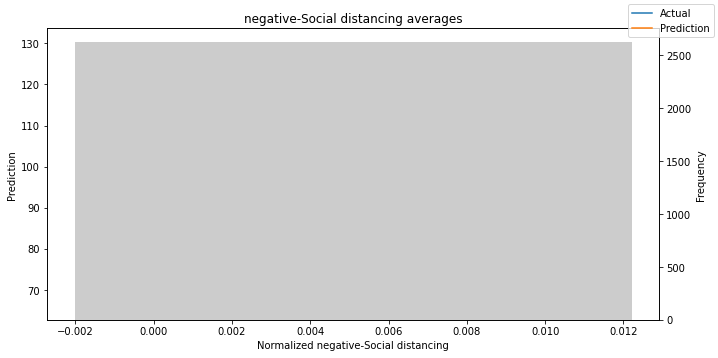

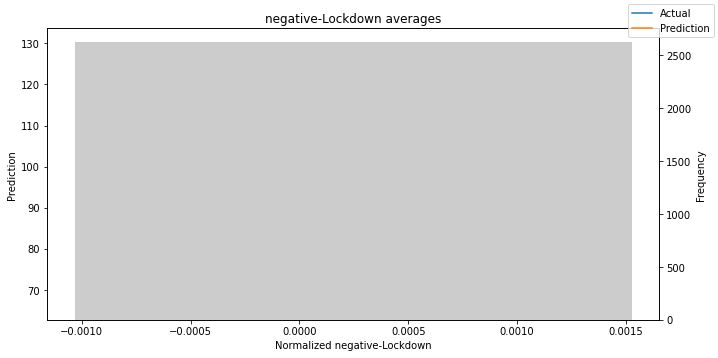

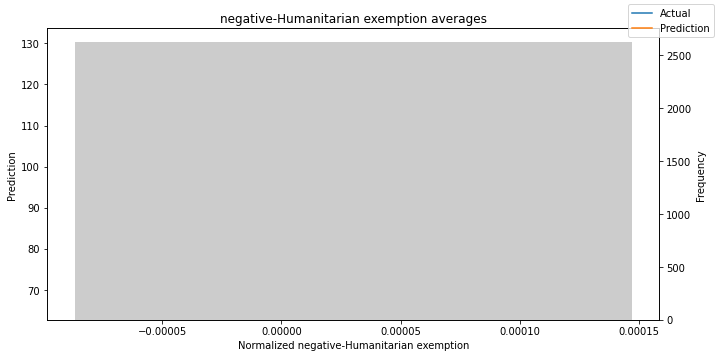

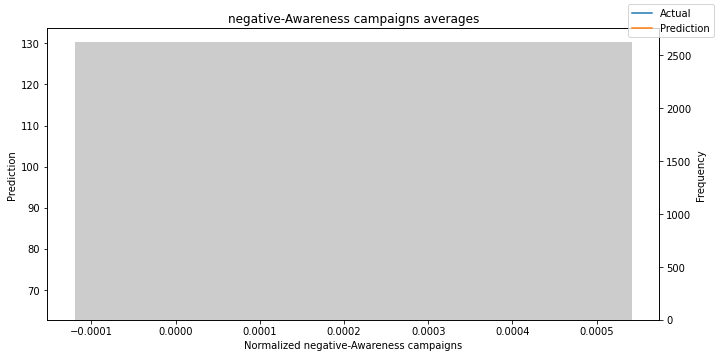

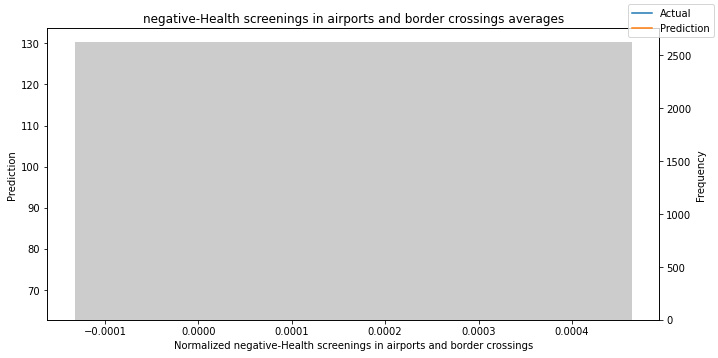

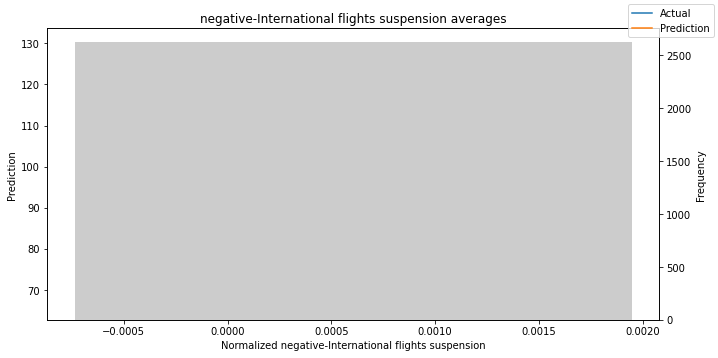

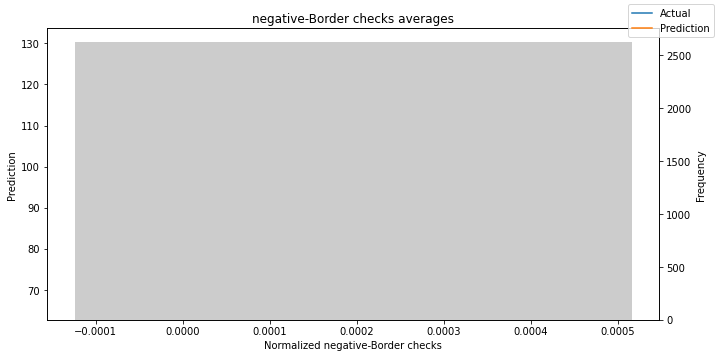

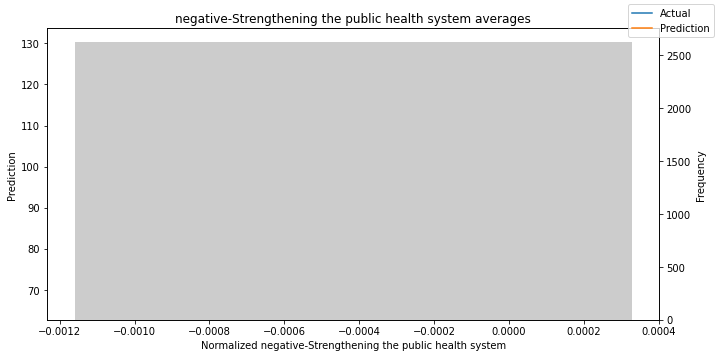

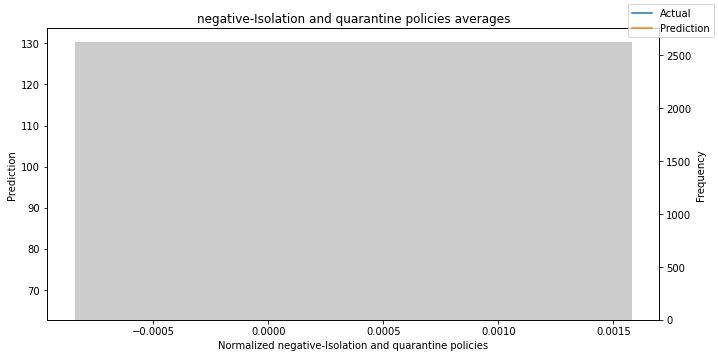

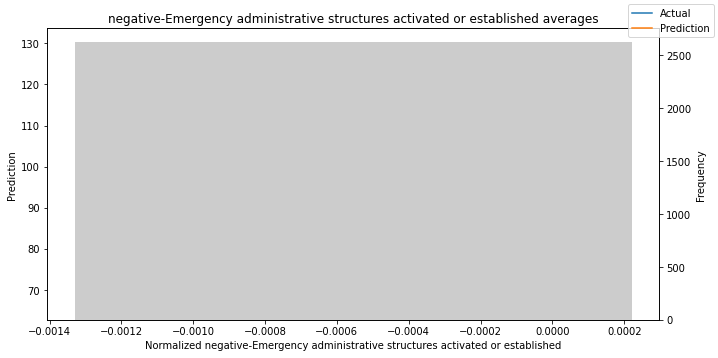

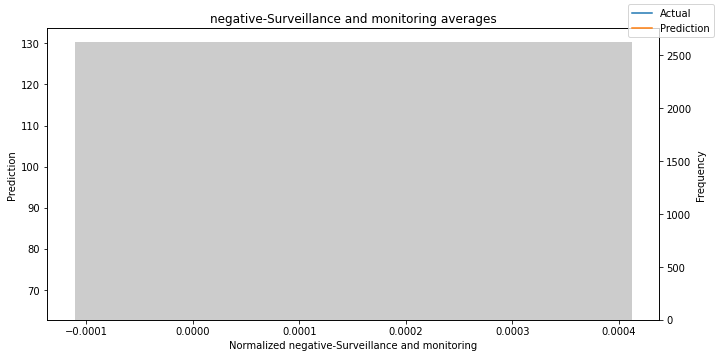

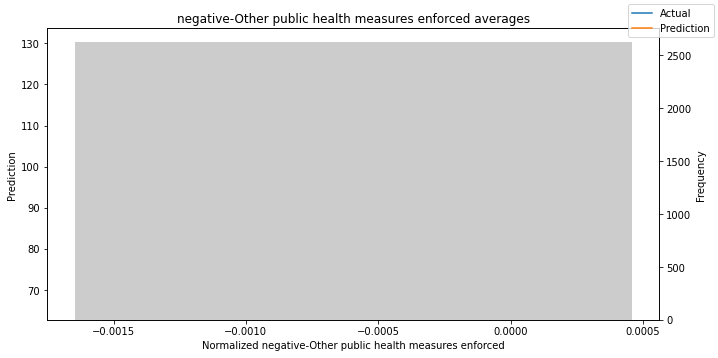

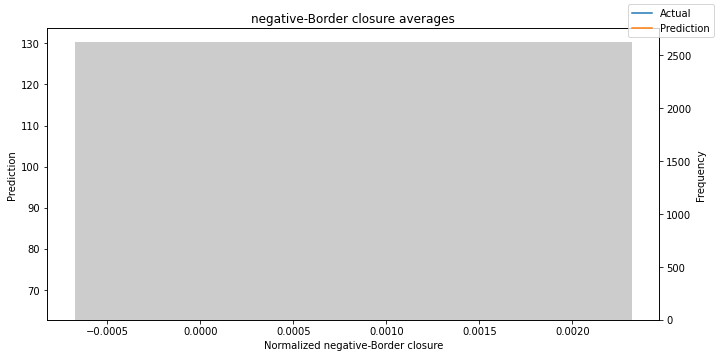

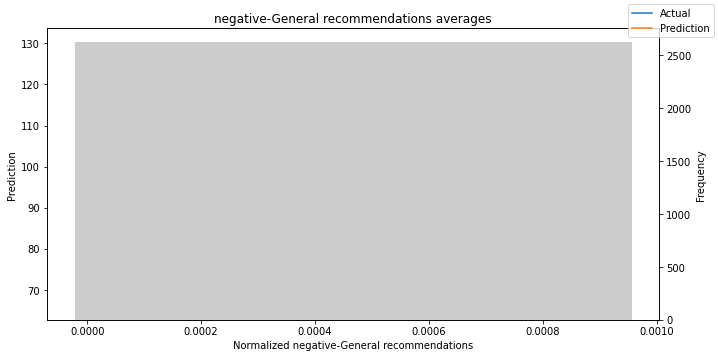

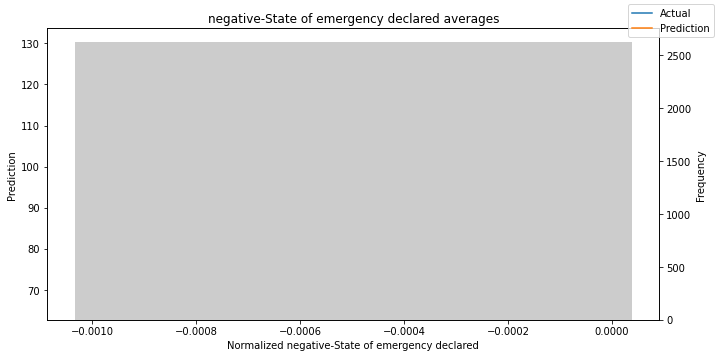

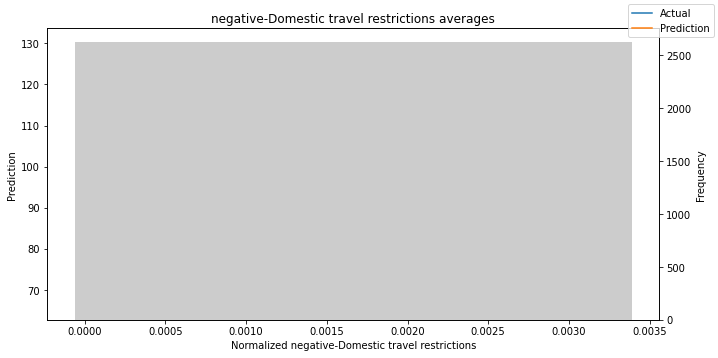

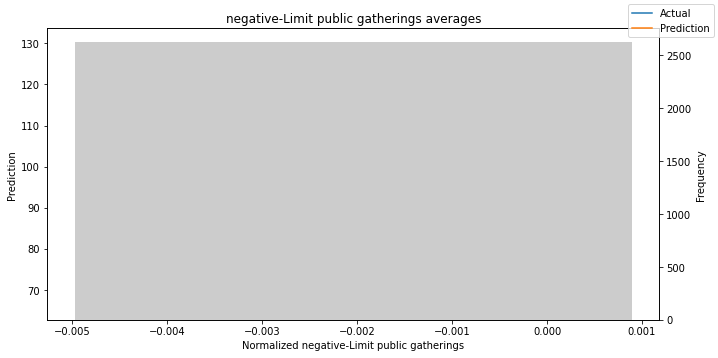

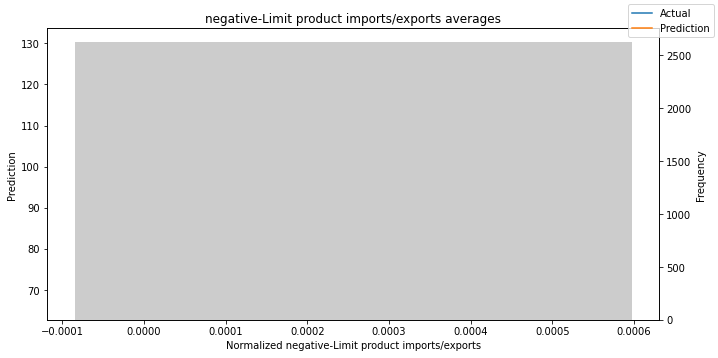

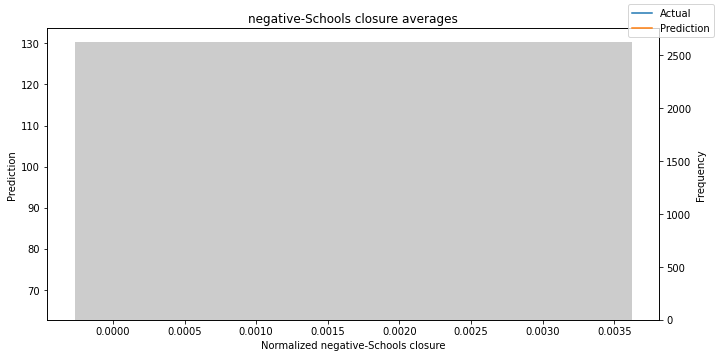

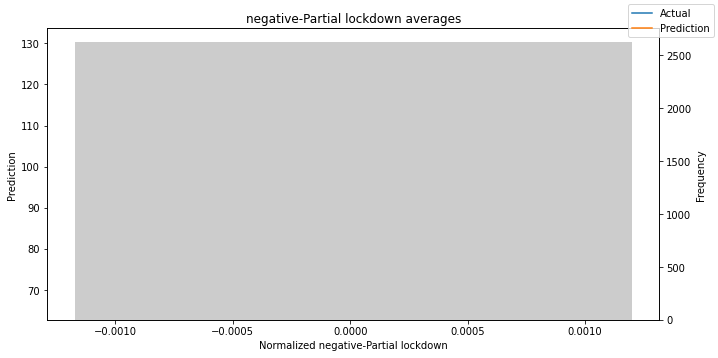

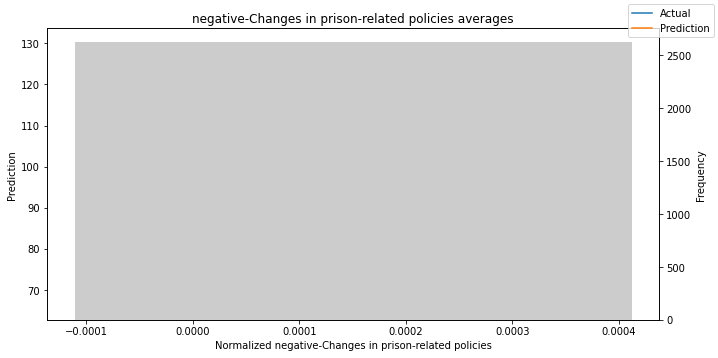

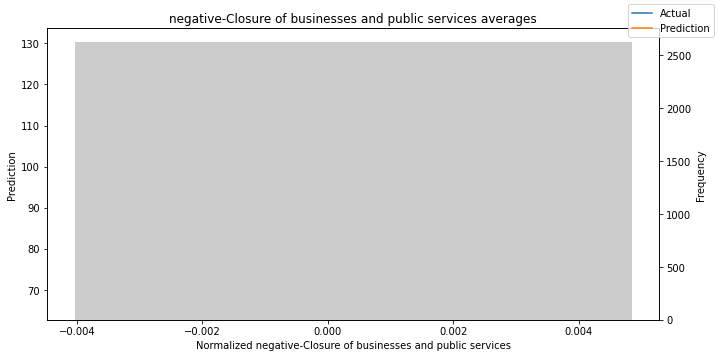

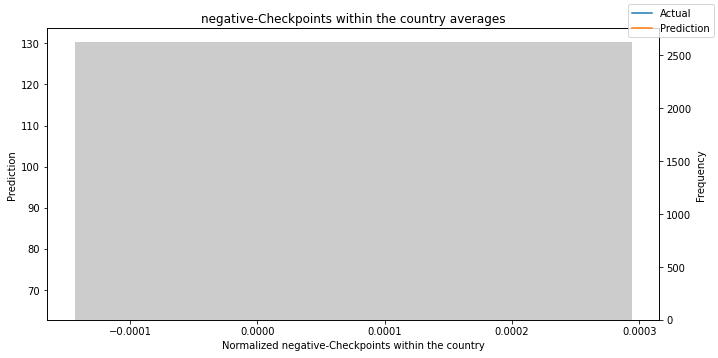

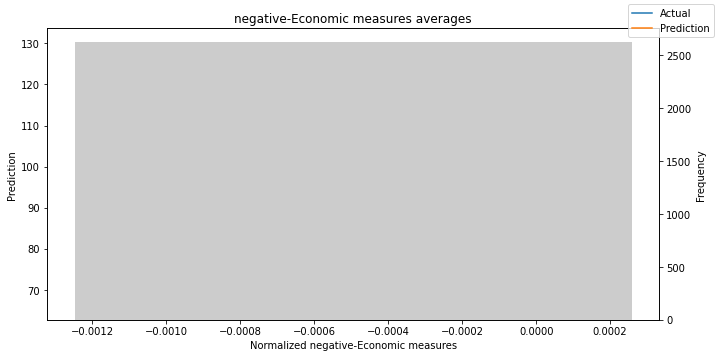

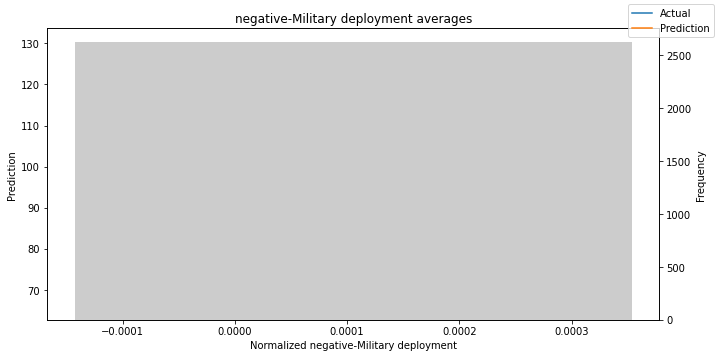

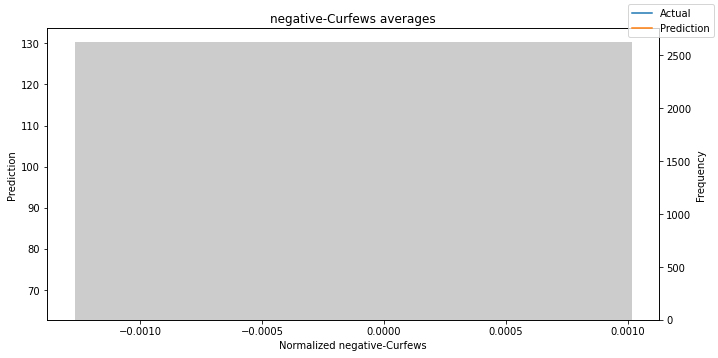

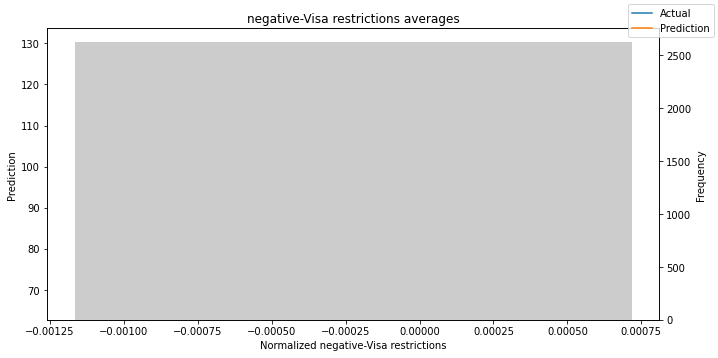

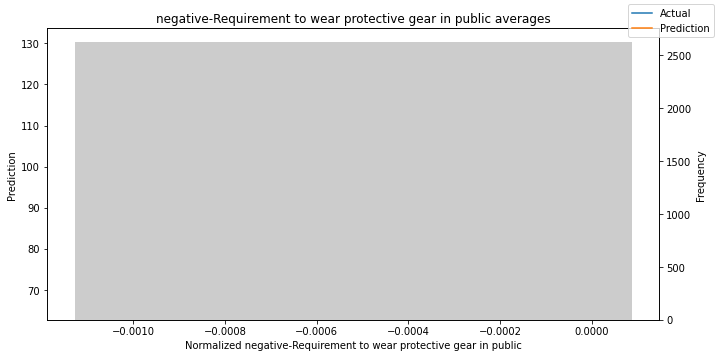

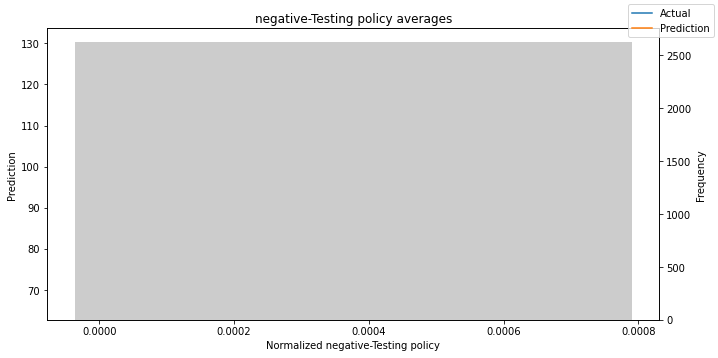

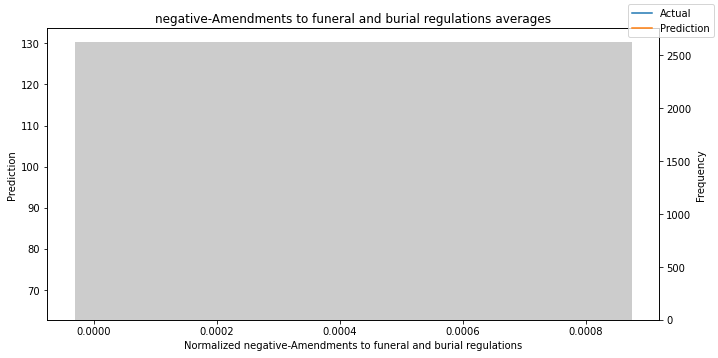

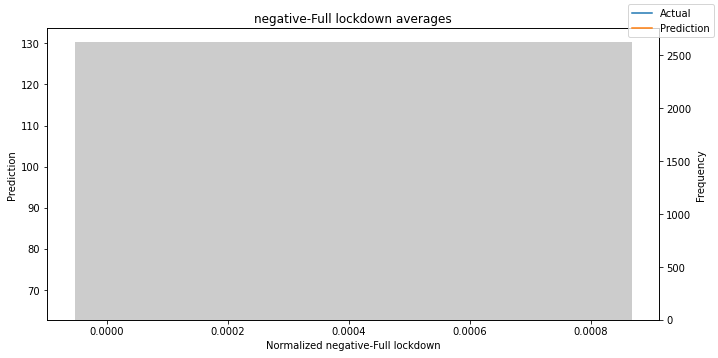

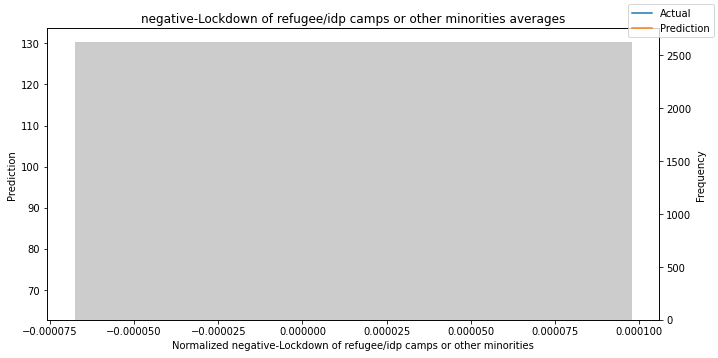

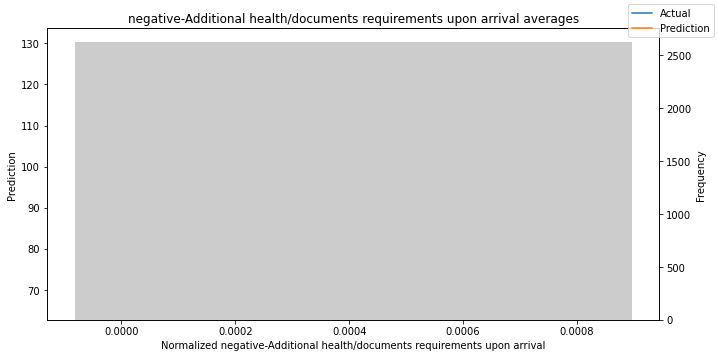

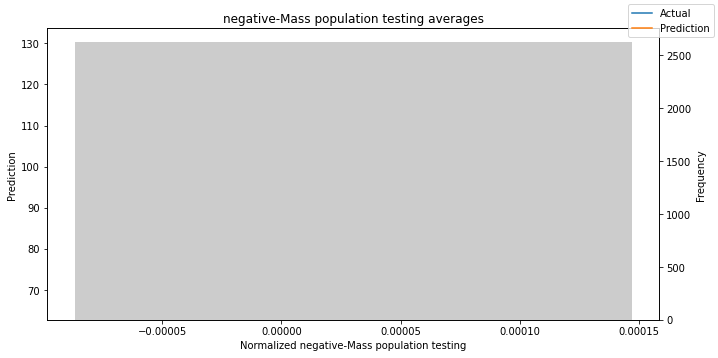

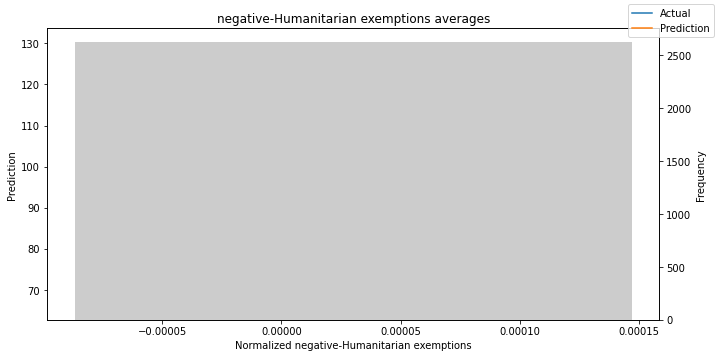

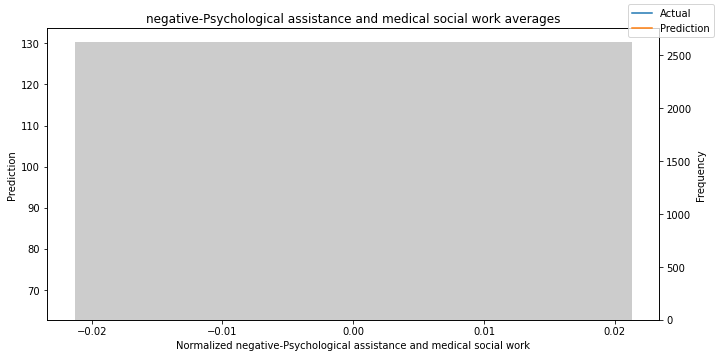

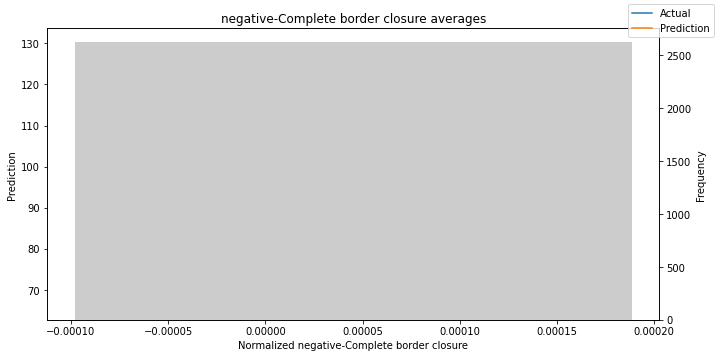

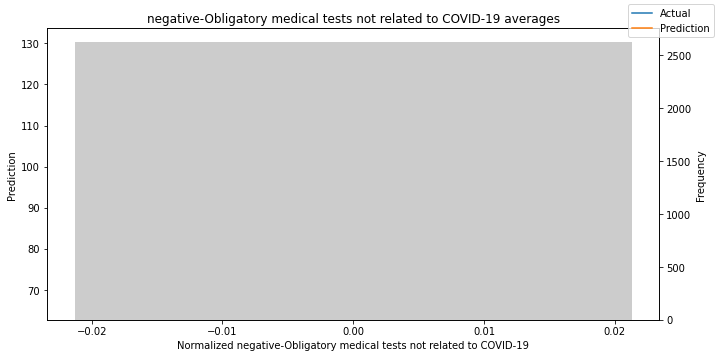

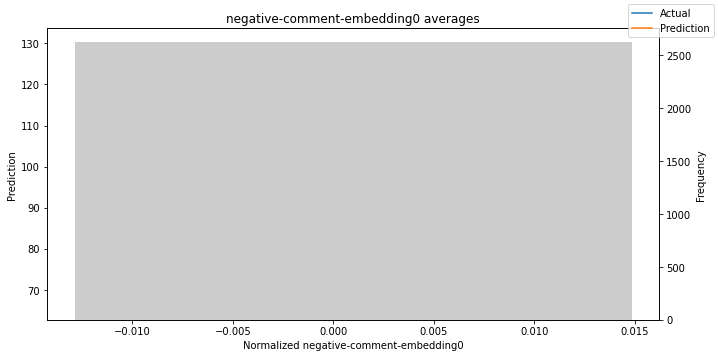

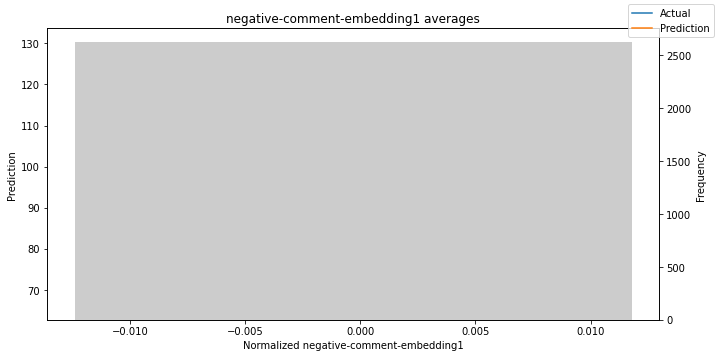

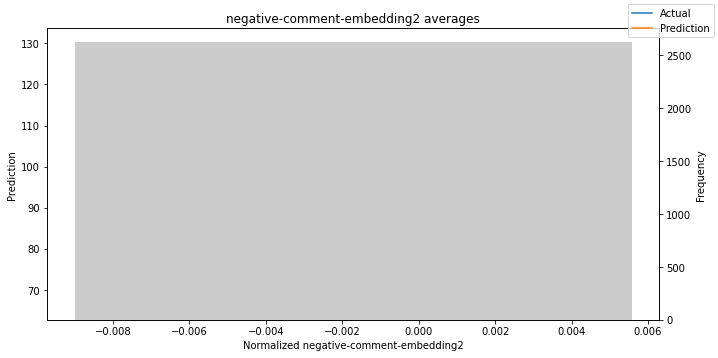

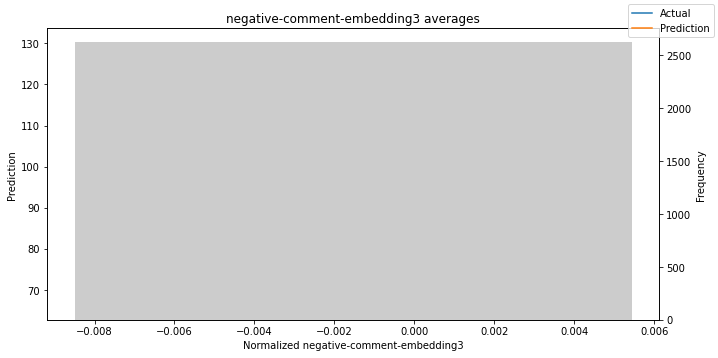

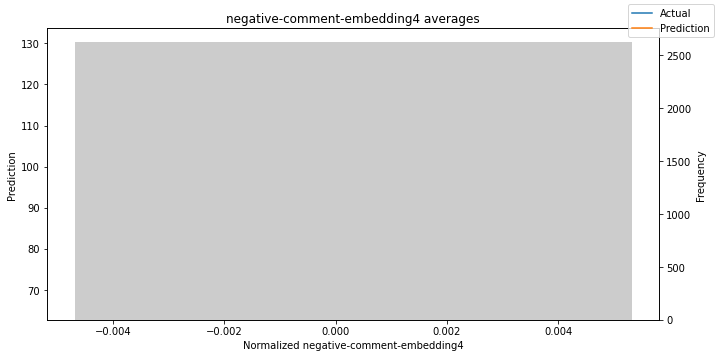

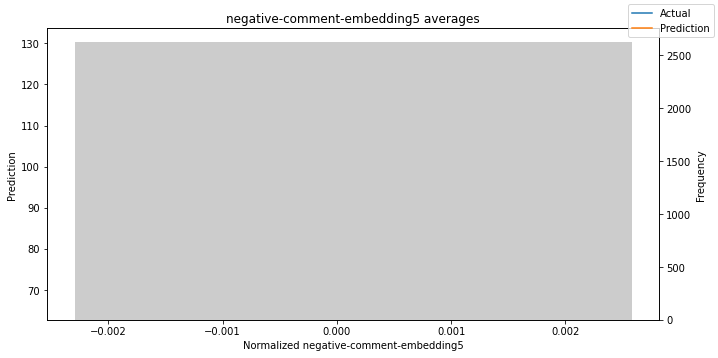

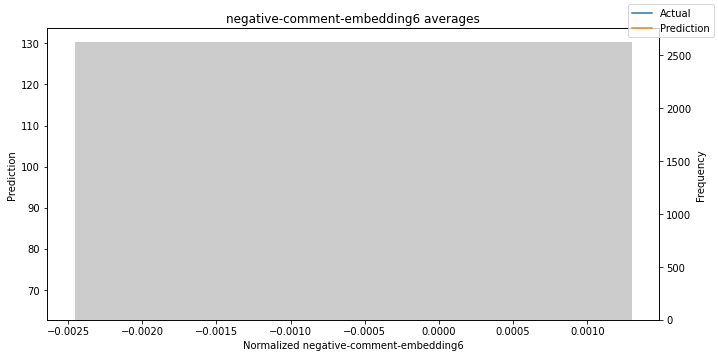

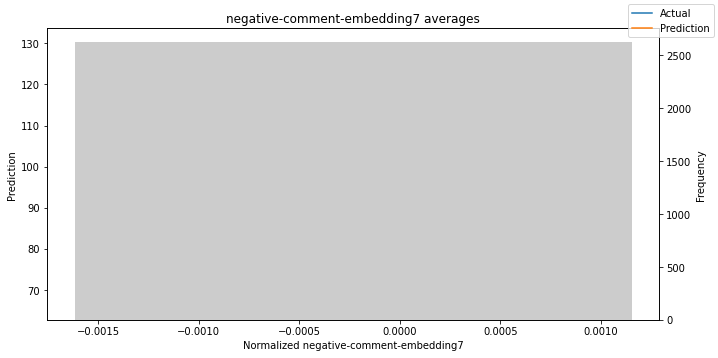

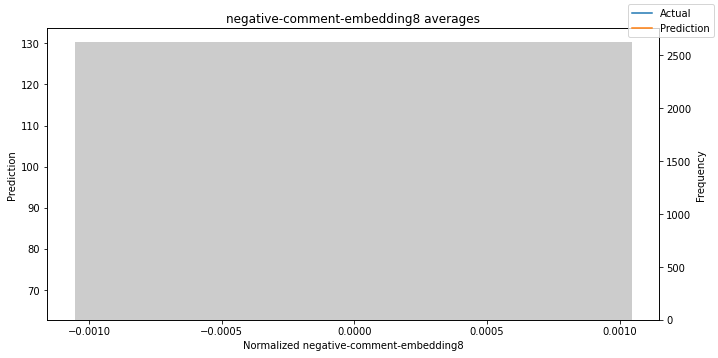

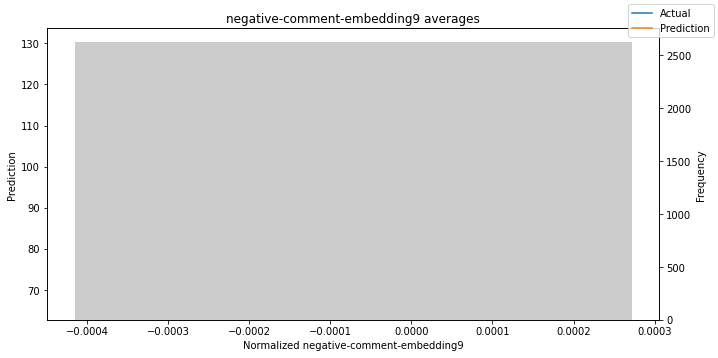

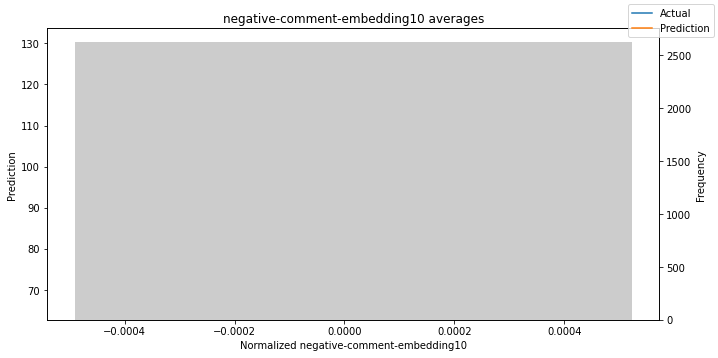

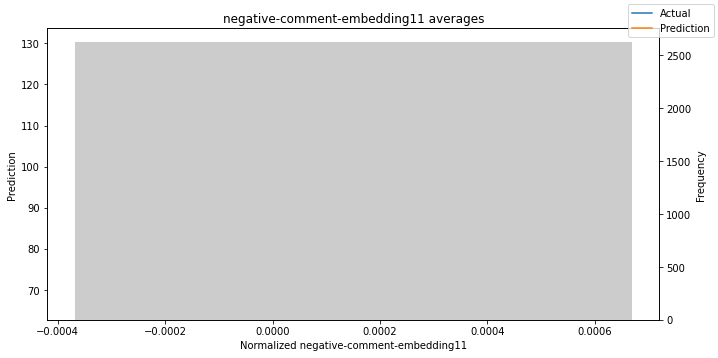

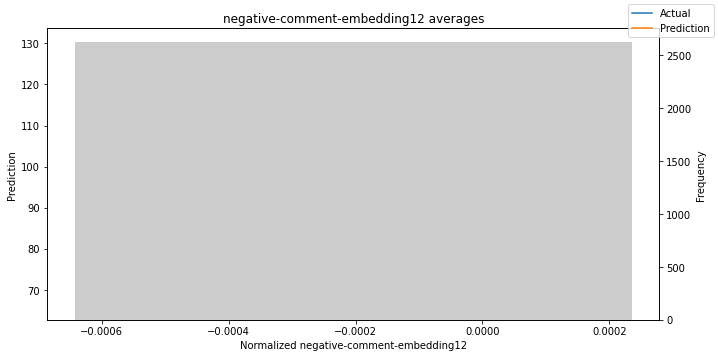

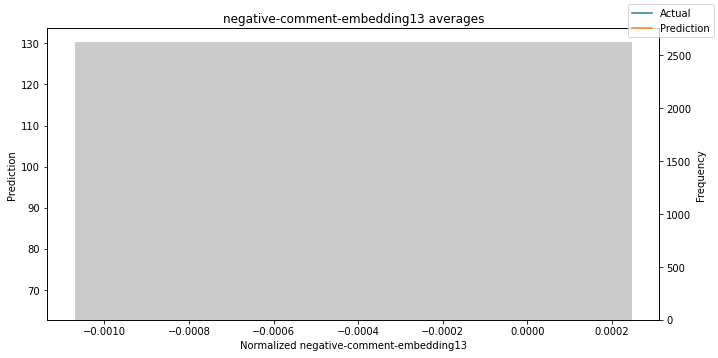

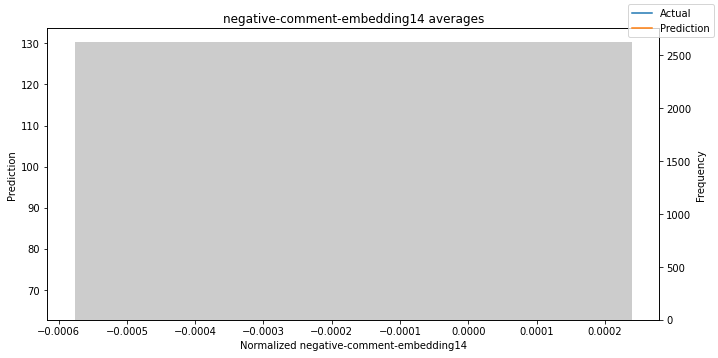

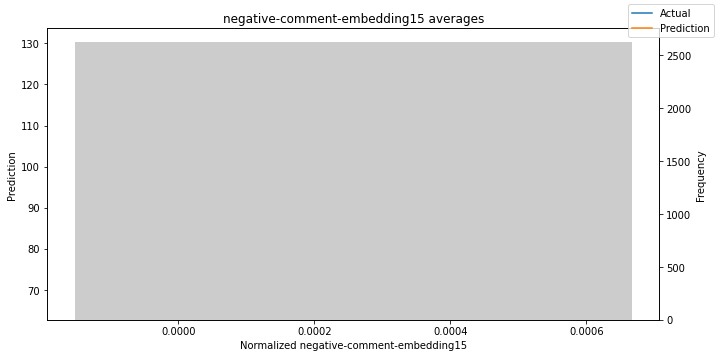

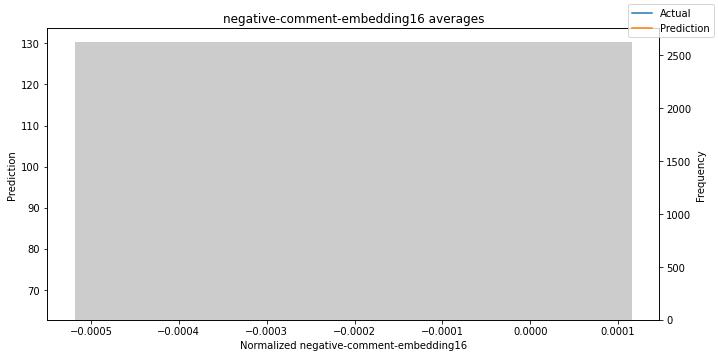

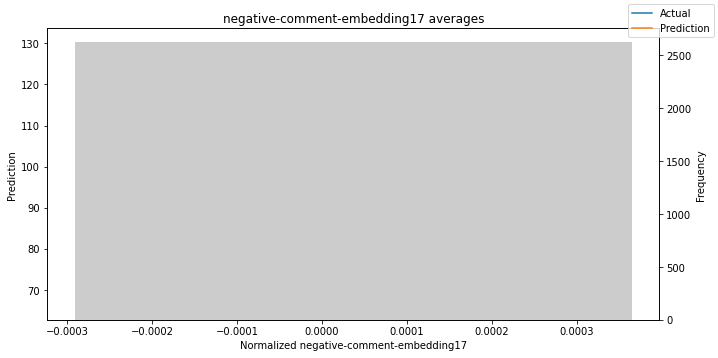

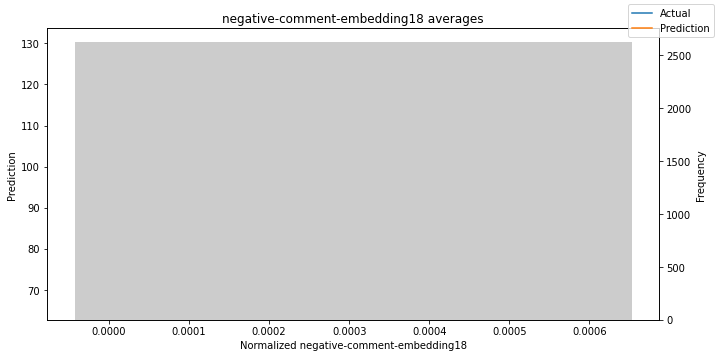

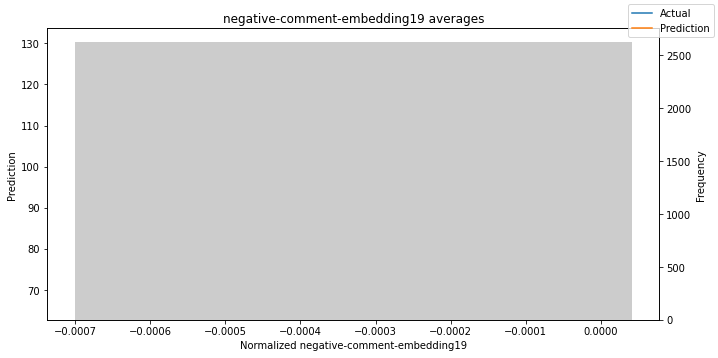

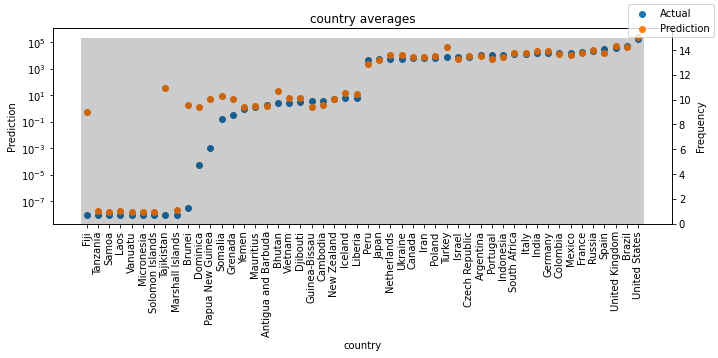

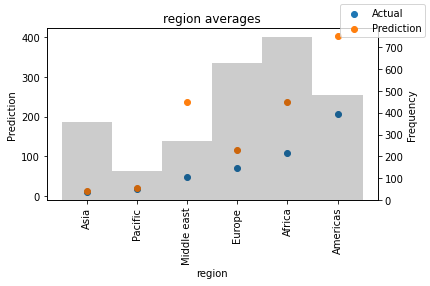

In [22]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);


{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>,
 'encoder_variables': <Figure size 504x2376 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>}

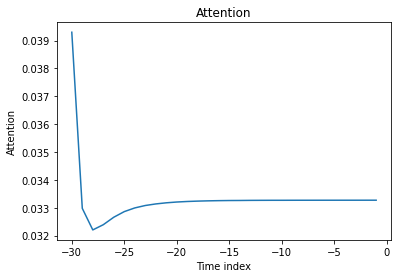

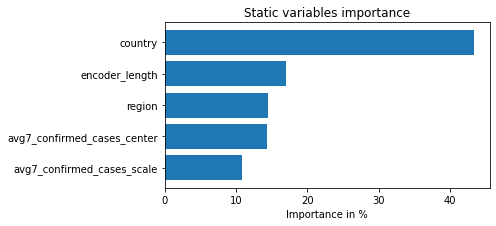

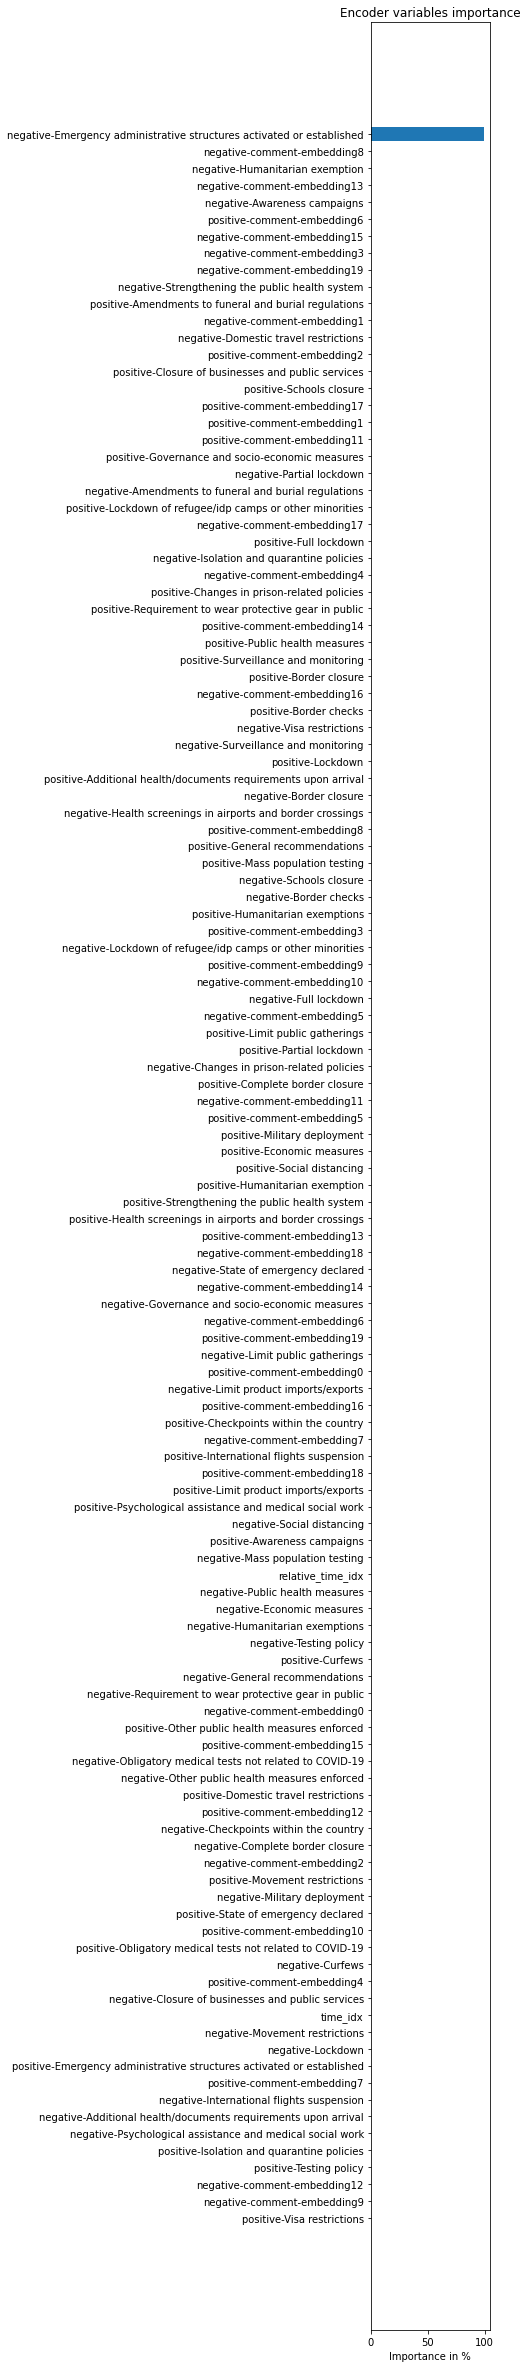

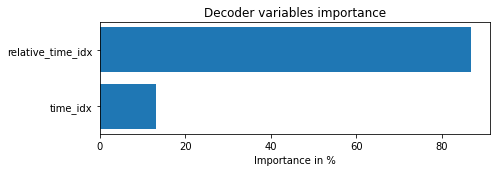

In [23]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)